# Data Preparation and Cleaning

## Importing Libraries

In [91]:
# Standard libraries
import datetime
import json
import os
import time
from collections import Counter
from urllib.request import urlopen

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.sparse import hstack, csr_matrix

# Machine Learning libraries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn import linear_model, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Natural Language Processing libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
from PIL import Image

# Explainability and model interpretation libraries
import eli5
import shap
import ast

# Setup for certain libraries
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('ggplot')

# Set of stopwords from NLTK
stop = set(stopwords.words('english'))

## Data Extraction

In [92]:
#extracting data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
test.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

## Data Cleaning

In [93]:
#replacing columns that contain NAN cells with empty dictionaries and transforming dictionaries into proper format
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train = text_to_dict(train)
test = text_to_dict(test)

In [94]:
train.head()

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  ...  \
0  When Lou, who has become the "father of the In...    6.575393  ...   
1  Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2  Under the direction of a ruthless instructor, ...   64.299990  ...   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936  ...   
4  Marine Boy is the story of a former national s...    1.148070  ...   

  release_date runtime                                   spoken_languages  \
0      2/20/15    93.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1       8/6/04   113.0           [{'iso_639_1': 'en', 'name': 'English'}]   
2     10/10/14   105.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3       3/9/12   122.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
4       2/5/09   118.0           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   
2  Released    The road to greatness can take you to the edge.   
3  Released                                                NaN   
4  Released                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000  
3  [{'credit_id': '52fe48779251

## Data Preparation

### Prepping belongs_to_collection

In [95]:
#checking the contents of the belongs_to_collection column
for i, e in enumerate(train['belongs_to_collection'][:3]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}


In [96]:
#checking for the number of empty entries 
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64

In [97]:
#creating two new columns collection_name (stores information about what collection a movie belongs to) and has_collection (stores information about whether or not a movie belongs to a collection)
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

### cleaning genres

In [98]:
#checking the contents of the belongs_to_collection column
for i, e in enumerate(train['genres'][:3]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]


In [99]:
#checking for number of genres associated with each movie
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


genres
2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: count, dtype: int64

In [100]:
#checking for what genres are most common
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [101]:
#creating 17 new columns num_genres (stores the number of genres associated with each movie), all_genres (stores a string with all the genre names associated with each movie), and 15 binary columns named genre_ + top_genre that indicate whether a movie is of said genre (1) or not (0)
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

### cleaning production_companies

In [102]:
#checking the contents of the production_companies column
for i, e in enumerate(train['production_companies'][:3]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]


In [103]:
#checking for the number of production companies associated with each movie
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


production_companies
1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
10      7
11      7
12      3
15      2
16      2
13      1
14      1
17      1
Name: count, dtype: int64

In [104]:
#checking for which production companies are most common
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

In [105]:
#creating 32 new columns num_companies (stores the number of production companies associated with each movie), all_production_companies (stores a string with all the production companies associated with each movie), and 30 binary columns named production_company_ + top_companies that indicate whether a movie is made by said production company (1) or not (0)
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

### cleaning production_countries

In [106]:
#checking the contents of the production_countries column
for i, e in enumerate(train['production_countries'][:3]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [107]:
#checking for the number of production countries associated with each movie
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


production_countries
1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: count, dtype: int64

In [108]:
#checking for which production countries are most common
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [109]:
#creating 27 new columns num_countries (stores the number of production countries associated with each movie), all_countries (stores a string with all the production countries associated with each movie), and 25 binary columns named production_country_ + top_countries that indicate whether a movie is produced by said country (1) or not (0)
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

### cleaning spoken_languages

In [110]:
#checking the contents of the spoken language column
for i, e in enumerate(train['spoken_languages'][:3]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]


In [111]:
#checking for the number of spoken languages associated with each movie
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


spoken_languages
1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: count, dtype: int64

In [112]:
#checking for which spoken languages are most common
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [113]:
#creating 17 new columns num_languages (stores the number of spoken languages associated with each movie), all_languages (stores a string with all the spoken languages associated with each movie), and 15 binary columns named language_ + top_languages that indicate whether a langauge is spoken in said movie (1) or not (0)
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4242079002.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4242079002.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4242079002.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

### cleaning keywords

In [114]:
#checking the contents of the keywords column
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [115]:
#checking for the number of keywords associated with each movie
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


Keywords
5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: count, dtype: int64

In [116]:
#checking for which key words are most common
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_keywords for i in j]).most_common(30)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53),
 ('drug', 52),
 ('prison', 50),
 ('musical', 49),
 ('high school', 49),
 ('los angeles', 48),
 ('new york', 47),
 ('family', 45),
 ('father son relationship', 44),
 ('kidnapping', 41),
 ('investigation', 41)]

In [117]:
#creating 17 new columns num_keywords (stores the number of keywords associated with each movie), all_languages (stores a string with all the keywords associated with each movie), and 30 binary columns named keyword_ + top_keywords that indicate whether a langauge is spoken in said movie (1) or not (0)
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4235770668.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4235770668.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\4235770668.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

### cleaning cast

In [118]:
#checking the contents of the cast column
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [119]:
#checking for the number of casted persons associated with each movie
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


cast
15    212
16    165
10    135
13    129
12    124
11    122
17    118
9     118
18    115
14    110
Name: count, dtype: int64

In [120]:
#checking for which cast names are most common
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [121]:
#checking for which cast genders are most common
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()
#(genders: 0 = specified, 1 = female, 2 = male)

[(2, 27949), (0, 20329), (1, 13533)]

In [122]:
#checking for which cast characters are most common
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [123]:
#creating column num_cast (stores the number of cast persons associated with each movie)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)

#creating 15 binary columns named cast_name_ + top_cast_names that indicate whether a cast name is associated with said movie (1) or not (0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)

#creating 3 new columns genders_n_cast which stores the number of cast members of gender n associated with each movie (n = 0,1,2)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

#creating 15 binary columns named cast_character_ + top_cast_characters that indicate whether a cast character is associated with said movie (1) or not (0)
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
#same with test data
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\788762680.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

### cleaning crew

In [124]:
#checking the contents of the crew column
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [125]:
#checking for the number of crew persons associated with each movie
print('Number of crew persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of crew persons in films


crew
2     179
11    127
10    126
3     126
12    110
8     109
9     109
14    104
4     101
7      94
Name: count, dtype: int64

In [126]:
#checking for which crew names are most common
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [127]:
#checking for which crew jobs are most common
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [128]:
#checking for which crew jobs are most common
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [129]:
#checking for which crew departments are most common
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [130]:
#creating column num_crew (stores the number of crew persons associated with each movie)
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)

#creating 15 binary columns named crew_name_ + top_crew_names that indicate whether a crew name is associated with said movie (1) or not (0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)

#creating 3 new columns genders_n_crew which stores the number of crew members of gender n associated with each movie (n = 0,1,2)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

#creating 15 columns named jobs_ + top_crew_jobs that indicates how many crew members with said job are associated with said movie
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
    
#creating 15 columns named departments_ + top_crew_departments that indicates how many crew members with said department are associated with said movie
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
#same with test data
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1376814671.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

# Data Exploration

## Budget vs Revenue

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\3180575347.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Text(0.5, 1.0, 'Log Revenue vs log budget')

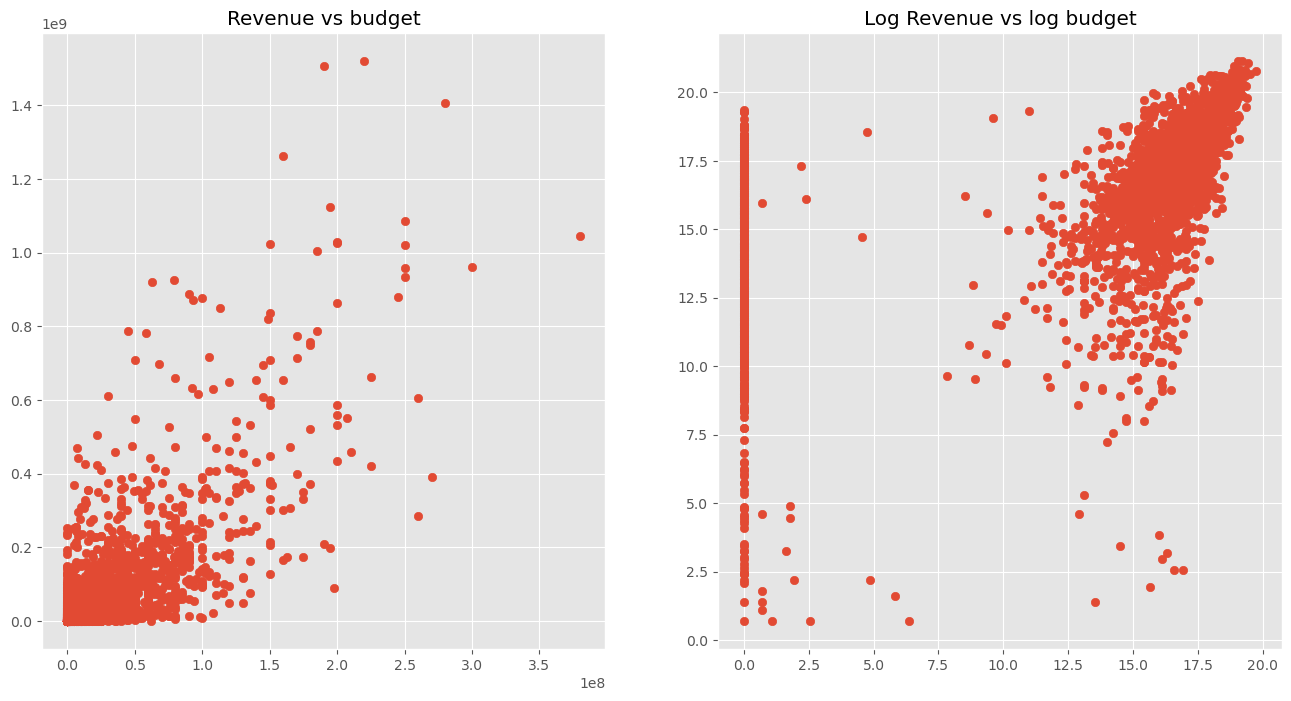

In [131]:
train['log_revenue'] = np.log1p(train['revenue']) #taking log of revenuw to make skewed distribution into one that is more symmetrical and closer to normal

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget')

## Original Language vs Revenue

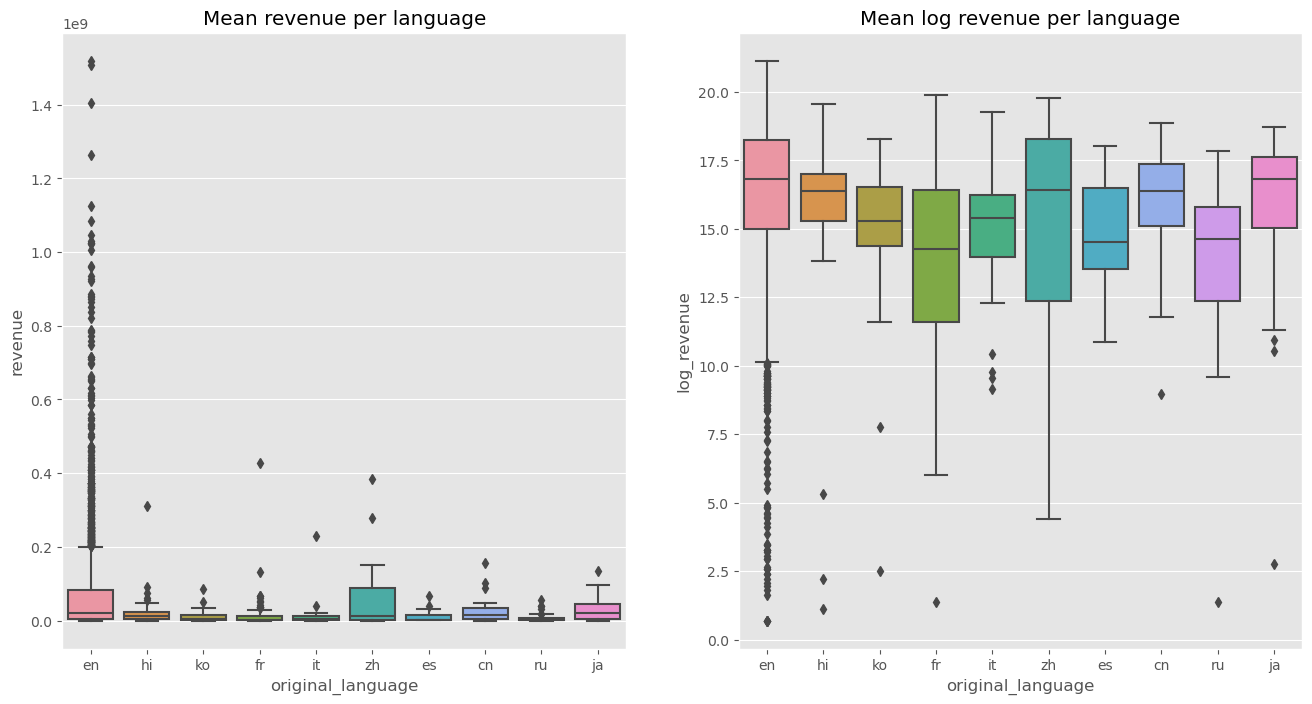

In [132]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

## Original Title vs Revenue

In [133]:
# Combine all titles into a single string
text = ' '.join(train['original_title'].values).lower()

# Tokenize the text into words
words = word_tokenize(text)

# Filter out stopwords and punctuation
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

# Count and display the most common words
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(10)  # Adjust the number as needed

print(most_common_words)

[('2', 62), ('man', 32), ('la', 31), ('last', 30), ('ii', 27), ('love', 25), ('movie', 21), ('life', 21), ('de', 20), ('american', 18)]


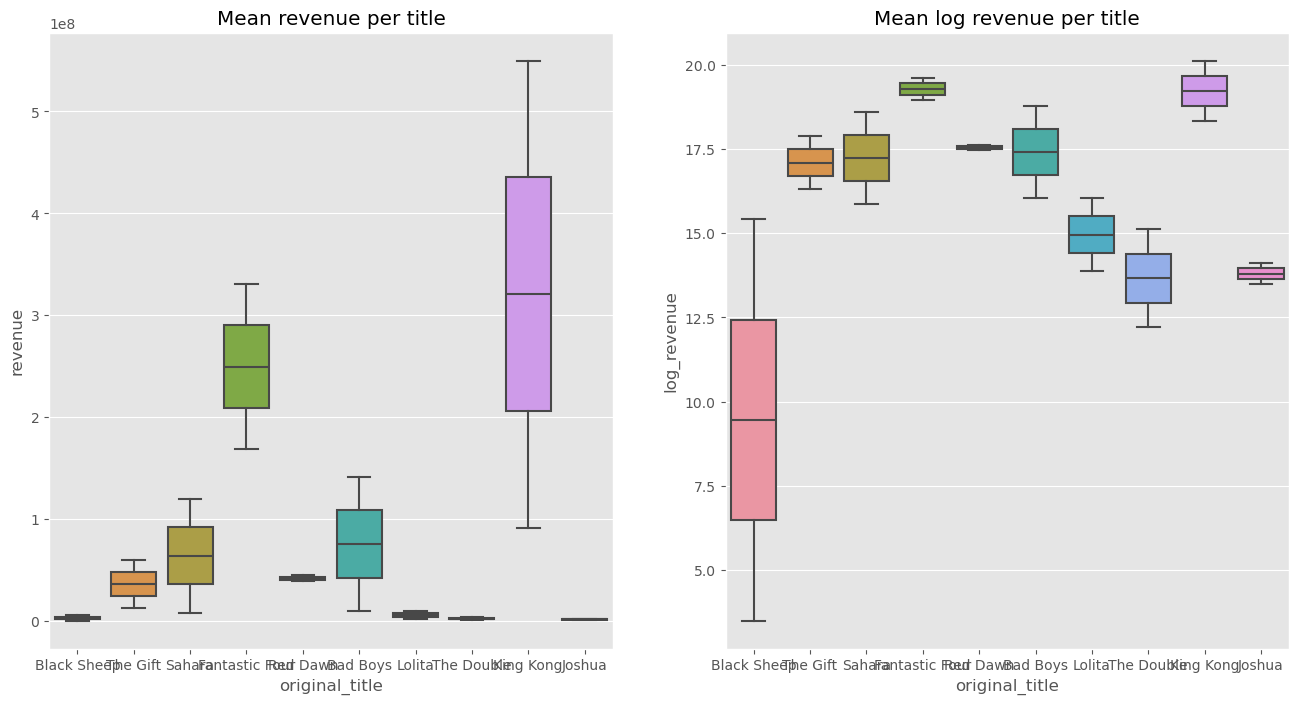

In [134]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_title', y='revenue', data=train.loc[train['original_title'].isin(train['original_title'].value_counts().head(10).index)]);
plt.title('Mean revenue per title');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_title', y='log_revenue', data=train.loc[train['original_title'].isin(train['original_title'].value_counts().head(10).index)]);
plt.title('Mean log revenue per title');

## Overview vs Revenue

In [135]:
# Combine all overviews into a single string, handling missing values
text = ' '.join(train['overview'].fillna('').values).lower()

# Tokenize the text into words
words = word_tokenize(text)

# Filter out stopwords and punctuation
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

# Count and display the most common words
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(10)  # Adjust the number as needed

print(most_common_words)

[('life', 559), ('new', 417), ('one', 399), ('young', 389), ('world', 340), ('love', 340), ('man', 337), ('two', 329), ('story', 306), ('family', 305)]


In [136]:
#TfidfVectorizer helps to transform the text from movie overviews into a TF-IDF matrix. Then we fit a linear regression model to predict log_revenue based on these transformed text features. Finally, we are using eli5 to show the weights of the linear regression model, giving an indication of the importance and influence of each term or phrase in the overviews on the predicted log_revenue.
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [137]:
#This output from eli5 helps in understanding which parts of the input text (in this case, movie overview) are influencing the prediction in a positive or negative way.
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


## Popularity vs Revenue

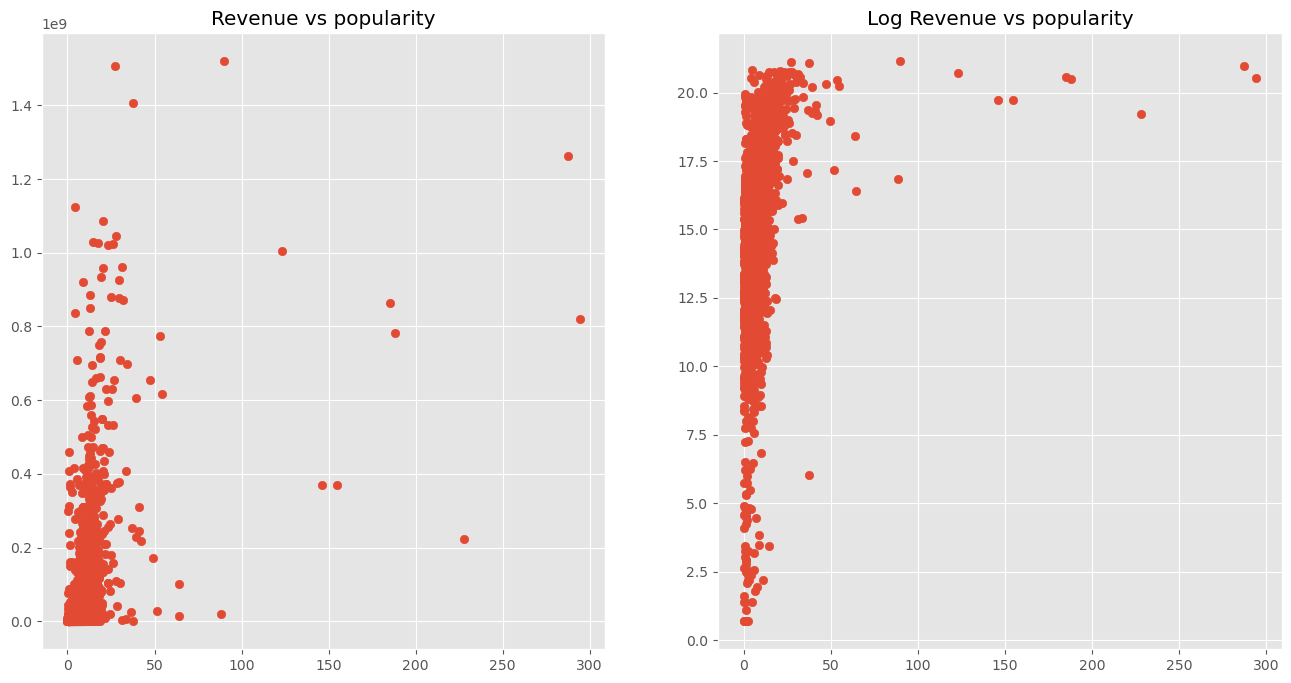

In [138]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');

## Release Data vs Revenue

In [139]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [140]:
#creating a function that converts data format from mm-dd-yy to yyyy-mm-dd
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [141]:
#updating the release_data column with the new date formats
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [142]:
# creating new data columns for different date_parts
def process_date(df):
    date_parts = ["year", "weekday", "month",'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1772598325.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1772598325.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\1772598325.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [143]:
# Count the number of films released each year in the training set and sort them by year
d1 = train['release_date_year'].value_counts().sort_index()

# Sum the total revenue for each year and group the results by year
d2 = train.groupby(['release_date_year'])['revenue'].sum()

# Prepare data for plotting: create scatter plots for the count of films and total revenue per year
data = [
    go.Scatter(x=d1.index, y=d1.values, name='film count'),  # Scatter plot showing the number of films per year
    go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')  # Scatter plot showing total revenue per year, using a second y-axis
]

# Define the layout of the plot, including the main title and axis labels
layout = go.Layout(
    dict(
        title = "Number of films and total revenue per year",  # Main title of the plot
        xaxis = dict(title = 'Year'),                          # Label for the x-axis
        yaxis = dict(title = 'Count'),                         # Label for the primary y-axis
        yaxis2=dict(
            title='Total revenue',                            # Label for the secondary y-axis
            overlaying='y',                                   # Specify that this axis overlays the primary y-axis
            side='right'                                      # Position this axis on the right side
        )
    ),
    legend=dict(orientation="v")  # Set legend orientation to vertical
)

# Plot the data using Plotly's offline plotting function
py.iplot(dict(data=data, layout=layout))

In [144]:
# Count the number of films released each year in the training set and sort them by year
d1 = train['release_date_year'].value_counts().sort_index()

# Calculate the average revenue for films each year and group the results by year
d2 = train.groupby(['release_date_year'])['revenue'].mean()

# Prepare data for plotting: create scatter plots for the count of films and average revenue per year
data = [
    go.Scatter(x=d1.index, y=d1.values, name='film count'),  # Scatter plot showing the number of films per year
    go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')  # Scatter plot showing average revenue per year, using a second y-axis
]

# Define the layout of the plot, including the main title and axis labels
layout = go.Layout(
    dict(
        title = "Number of films and average revenue per year",  # Main title of the plot
        xaxis = dict(title = 'Year'),                            # Label for the x-axis
        yaxis = dict(title = 'Count'),                           # Label for the primary y-axis
        yaxis2=dict(
            title='Average revenue',                            # Label for the secondary y-axis
            overlaying='y',                                     # Specify that this axis overlays the primary y-axis
            side='right'                                        # Position this axis on the right side
        )
    ),
    legend=dict(orientation="v")  # Set legend orientation to vertical
)

# Plot the data using Plotly's offline plotting function
py.iplot(dict(data=data, layout=layout))

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



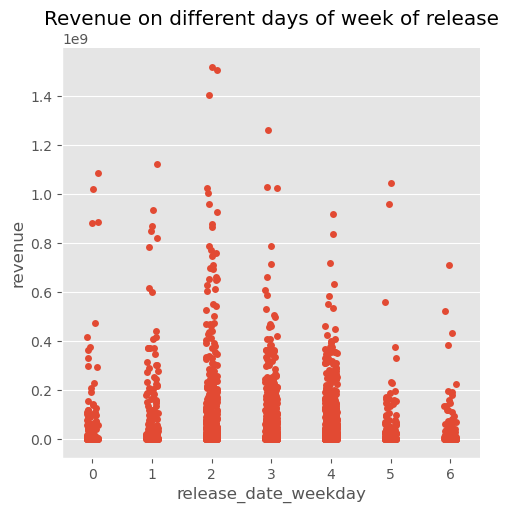

In [145]:
#checking if days of week of release affects revenue (0 = monday, 1 = tuesday, ..., 6 = sunday)
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

## Runtime vs Revenue

Text(0.5, 1.0, 'runtime vs popularity')

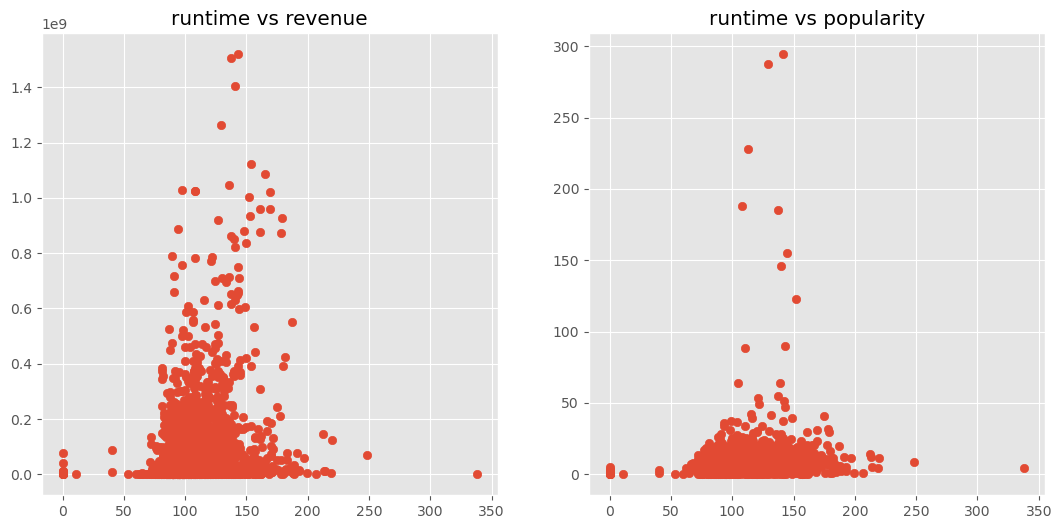

In [146]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity')

## Collections vs Revenue

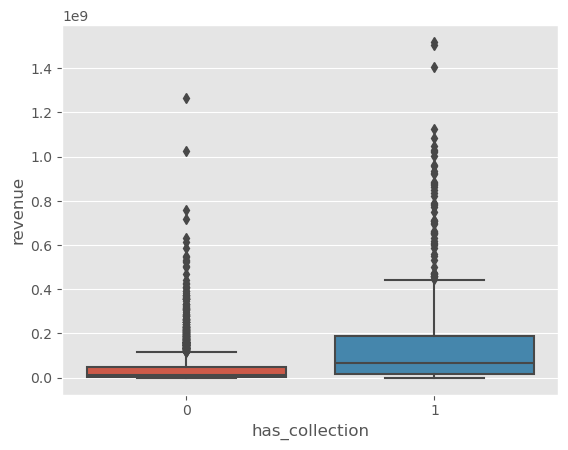

In [147]:
sns.boxplot(x='has_collection', y='revenue', data=train);

## Genres vs Revenue

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



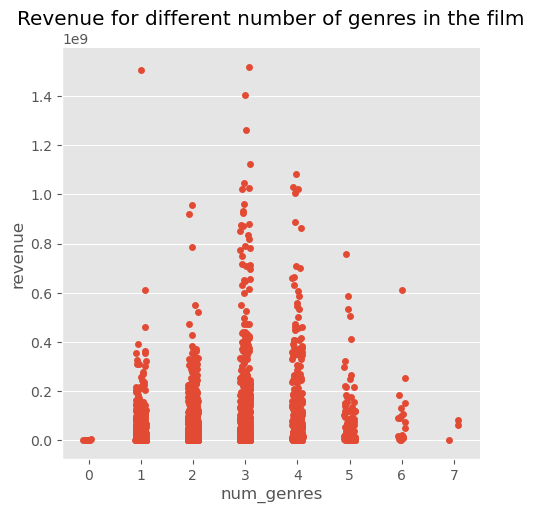

In [148]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

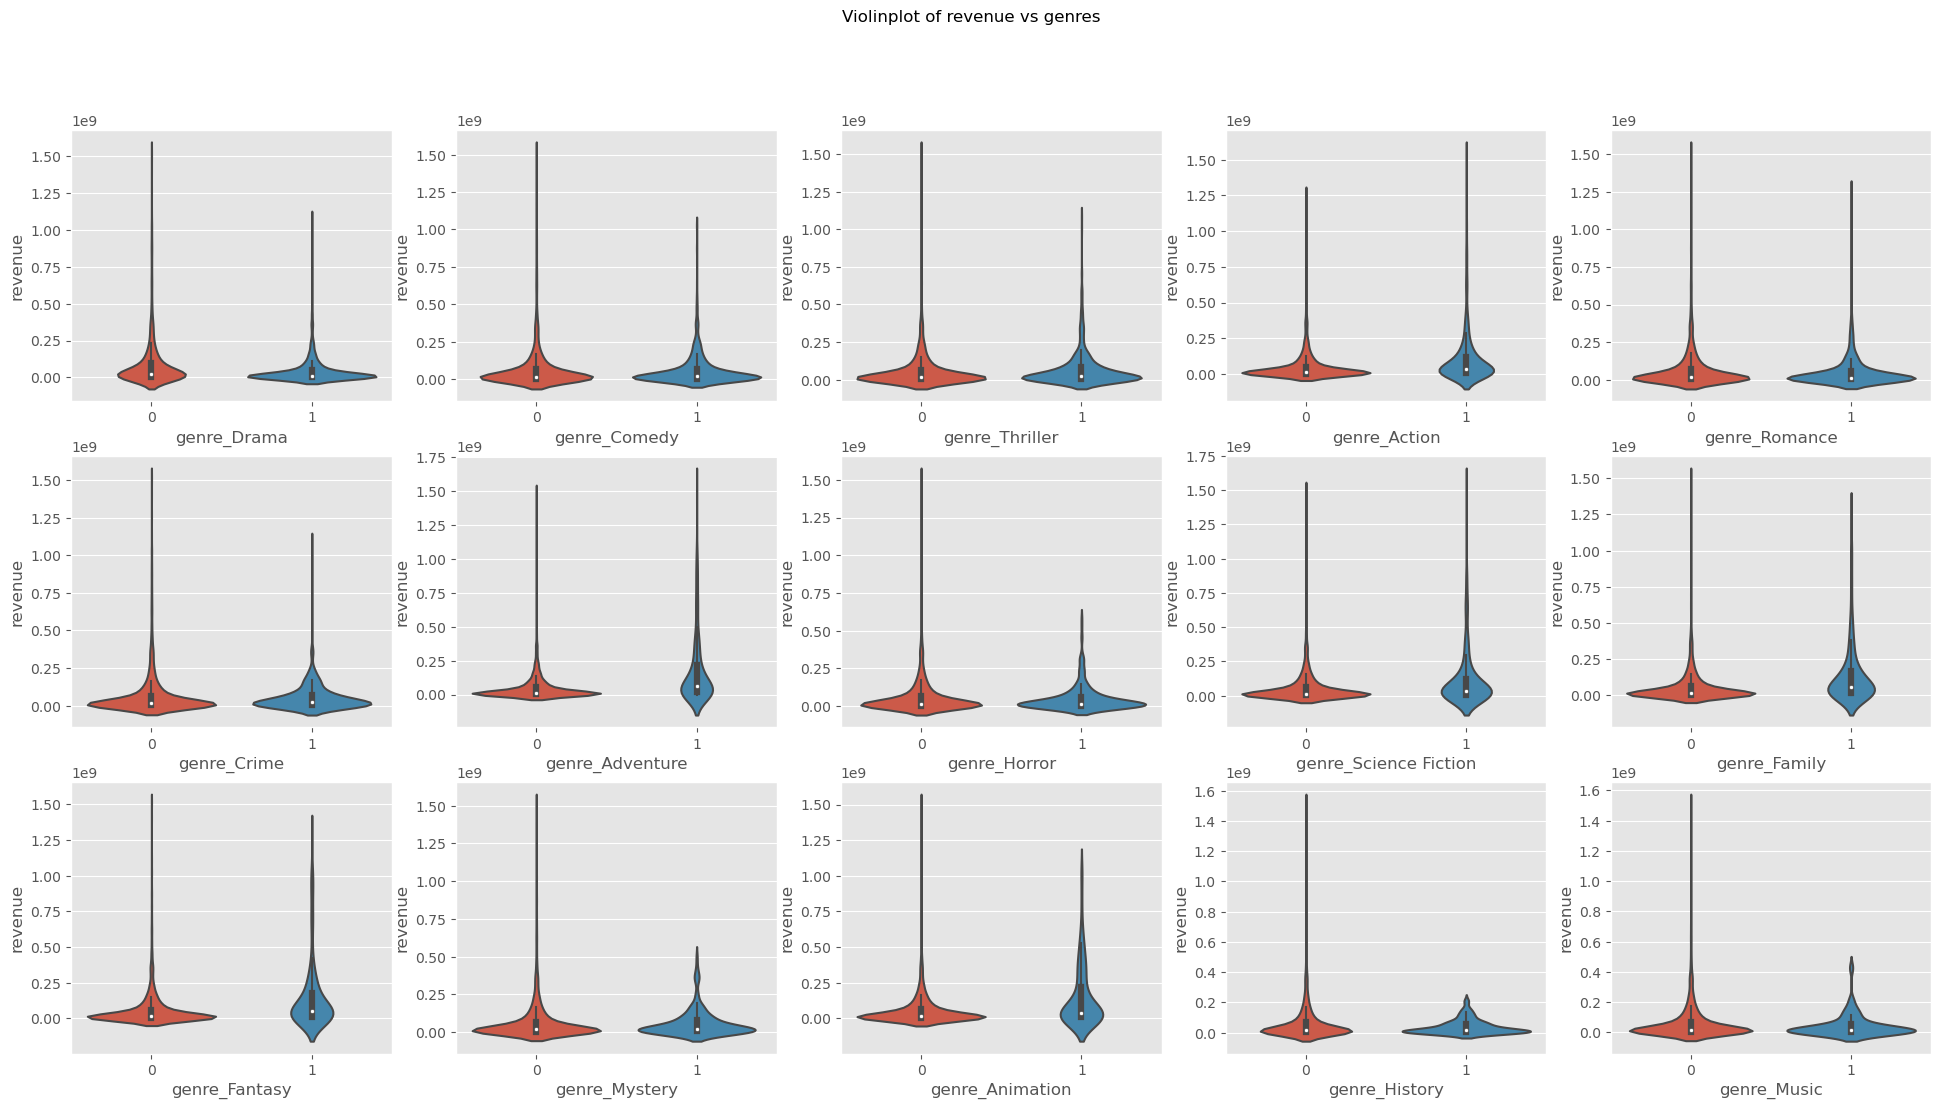

In [149]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Production Companies vs Revenue

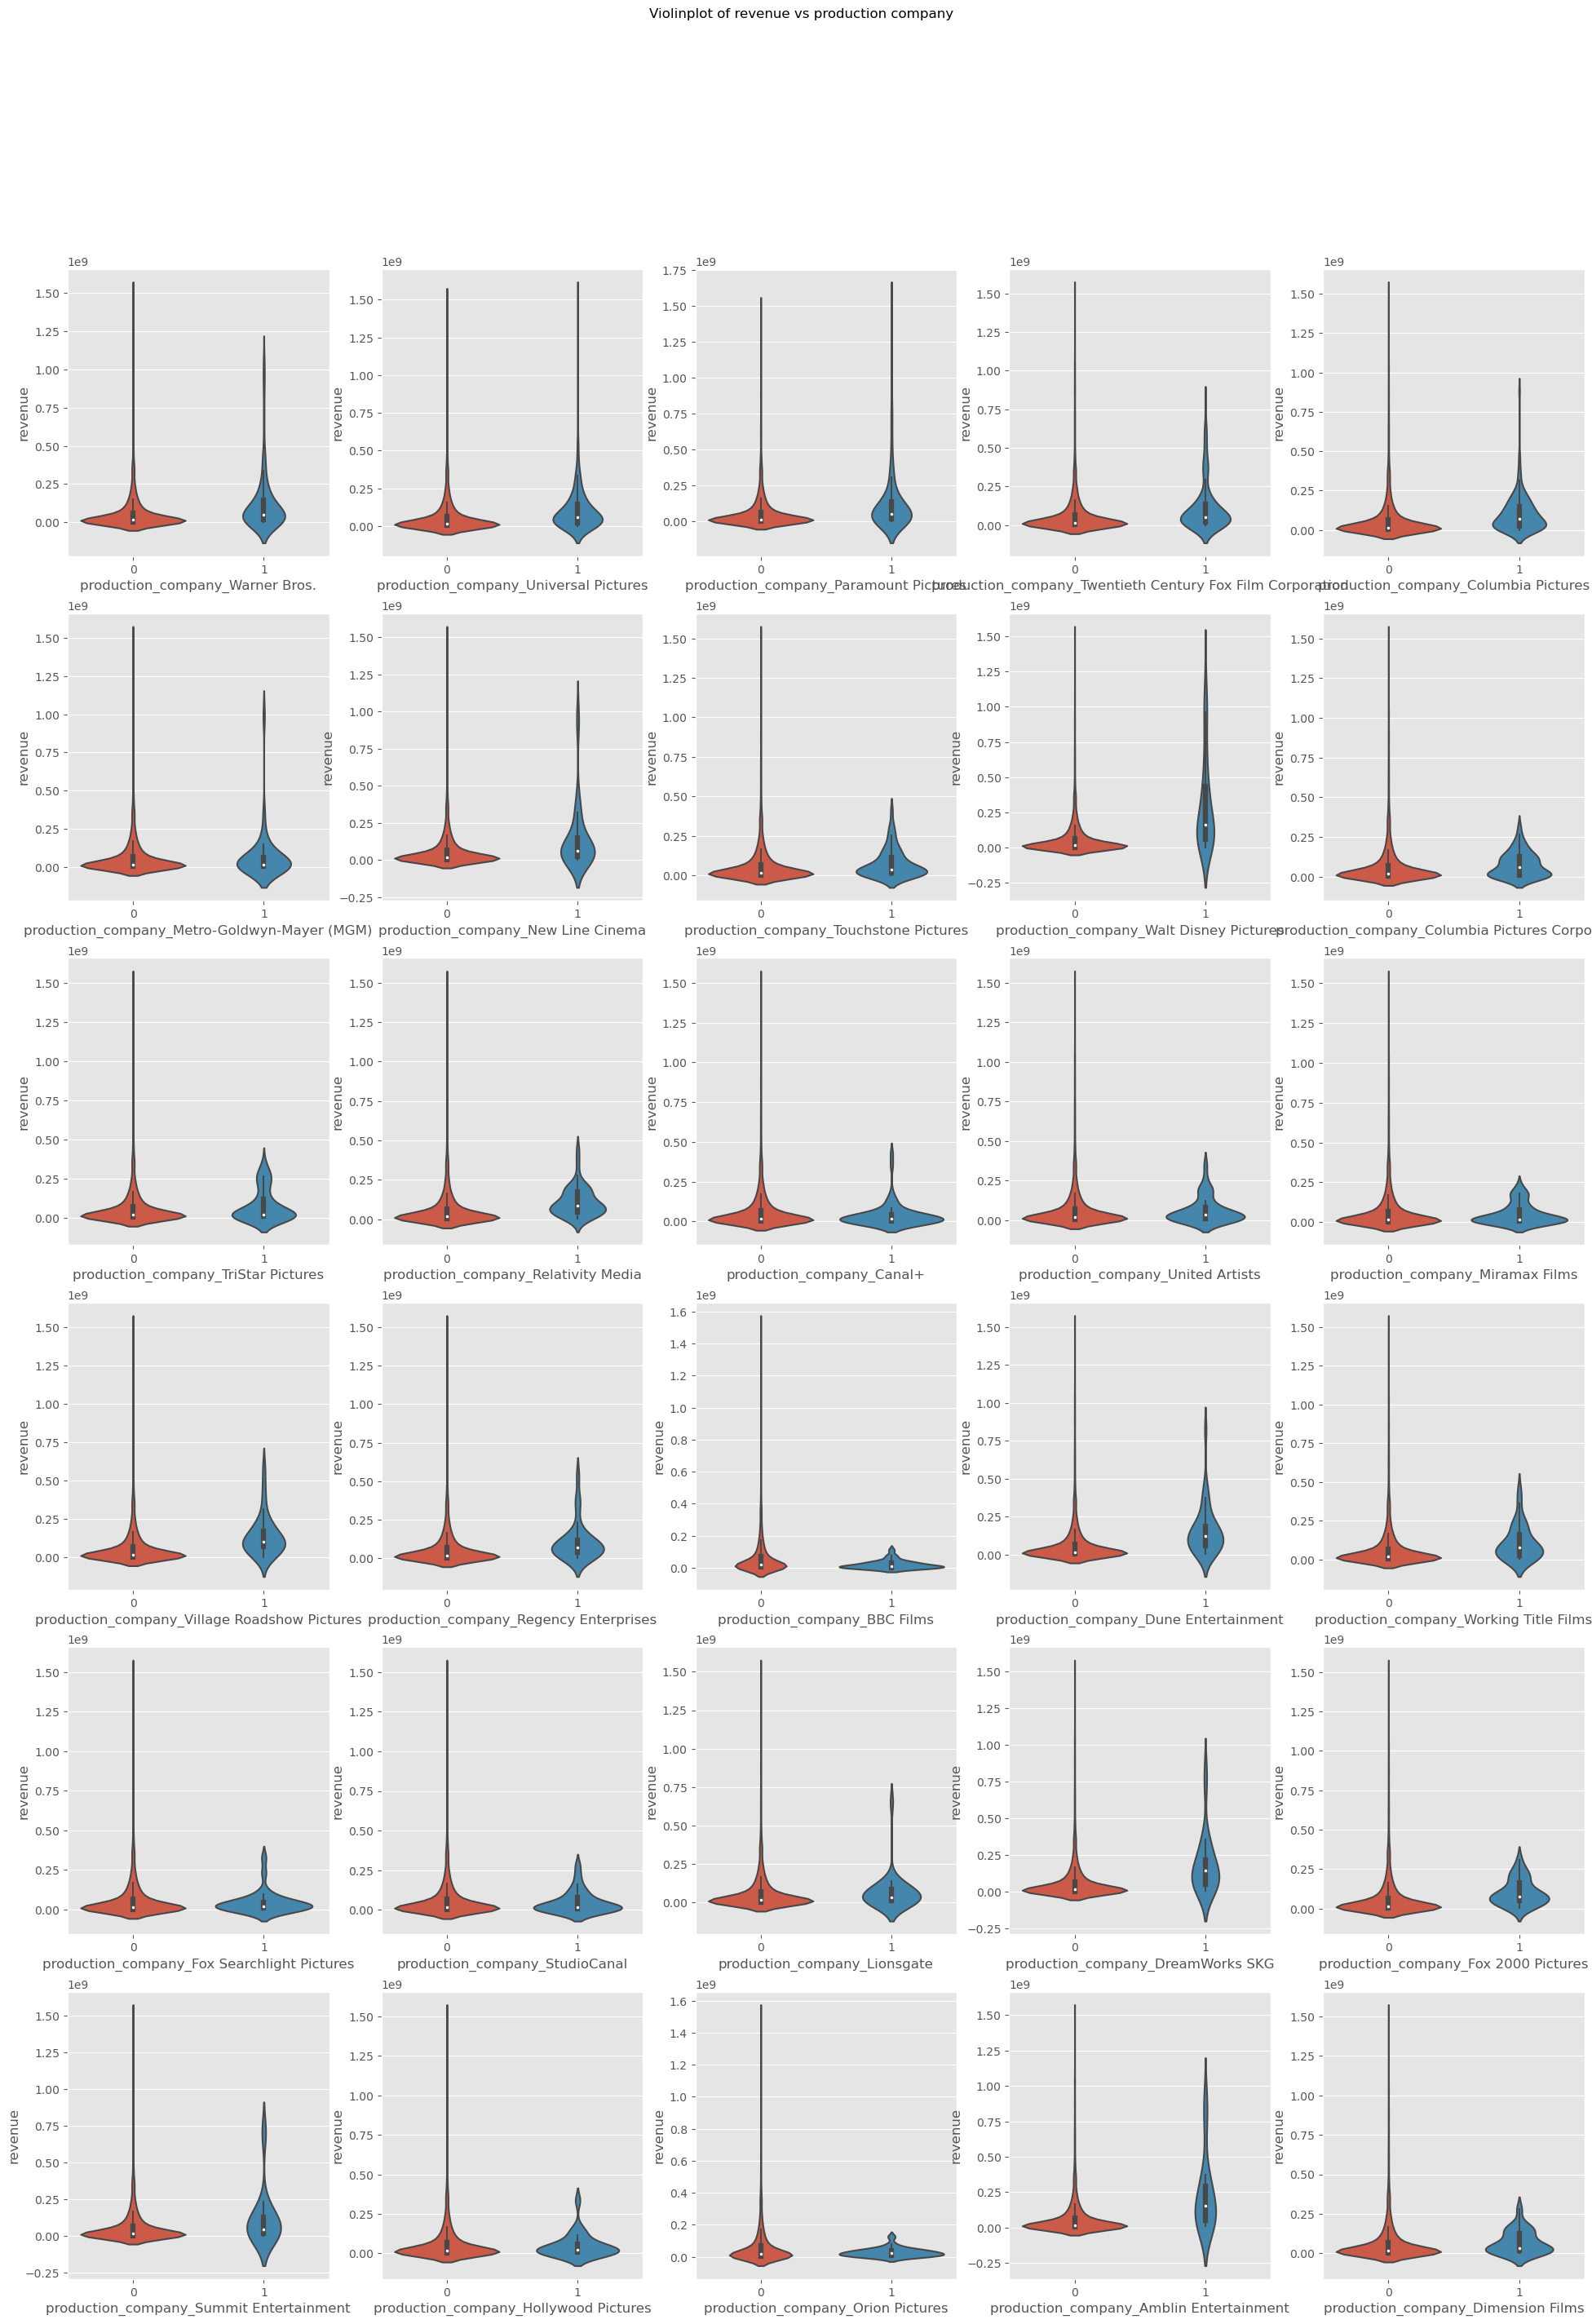

In [150]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



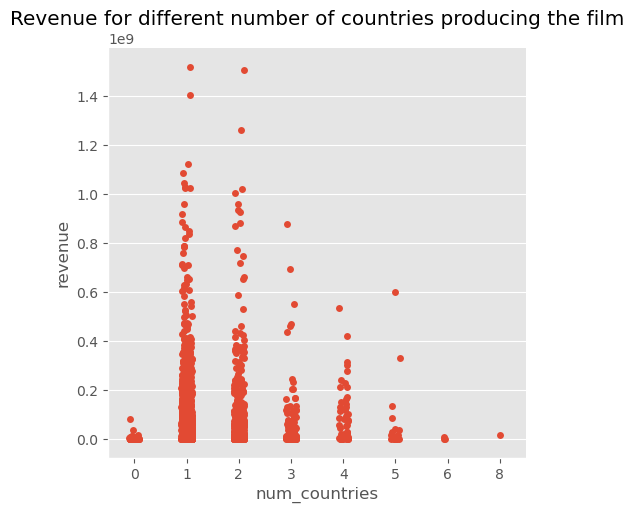

In [151]:
sns.catplot(x='num_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

## Production Countries vs Revenue

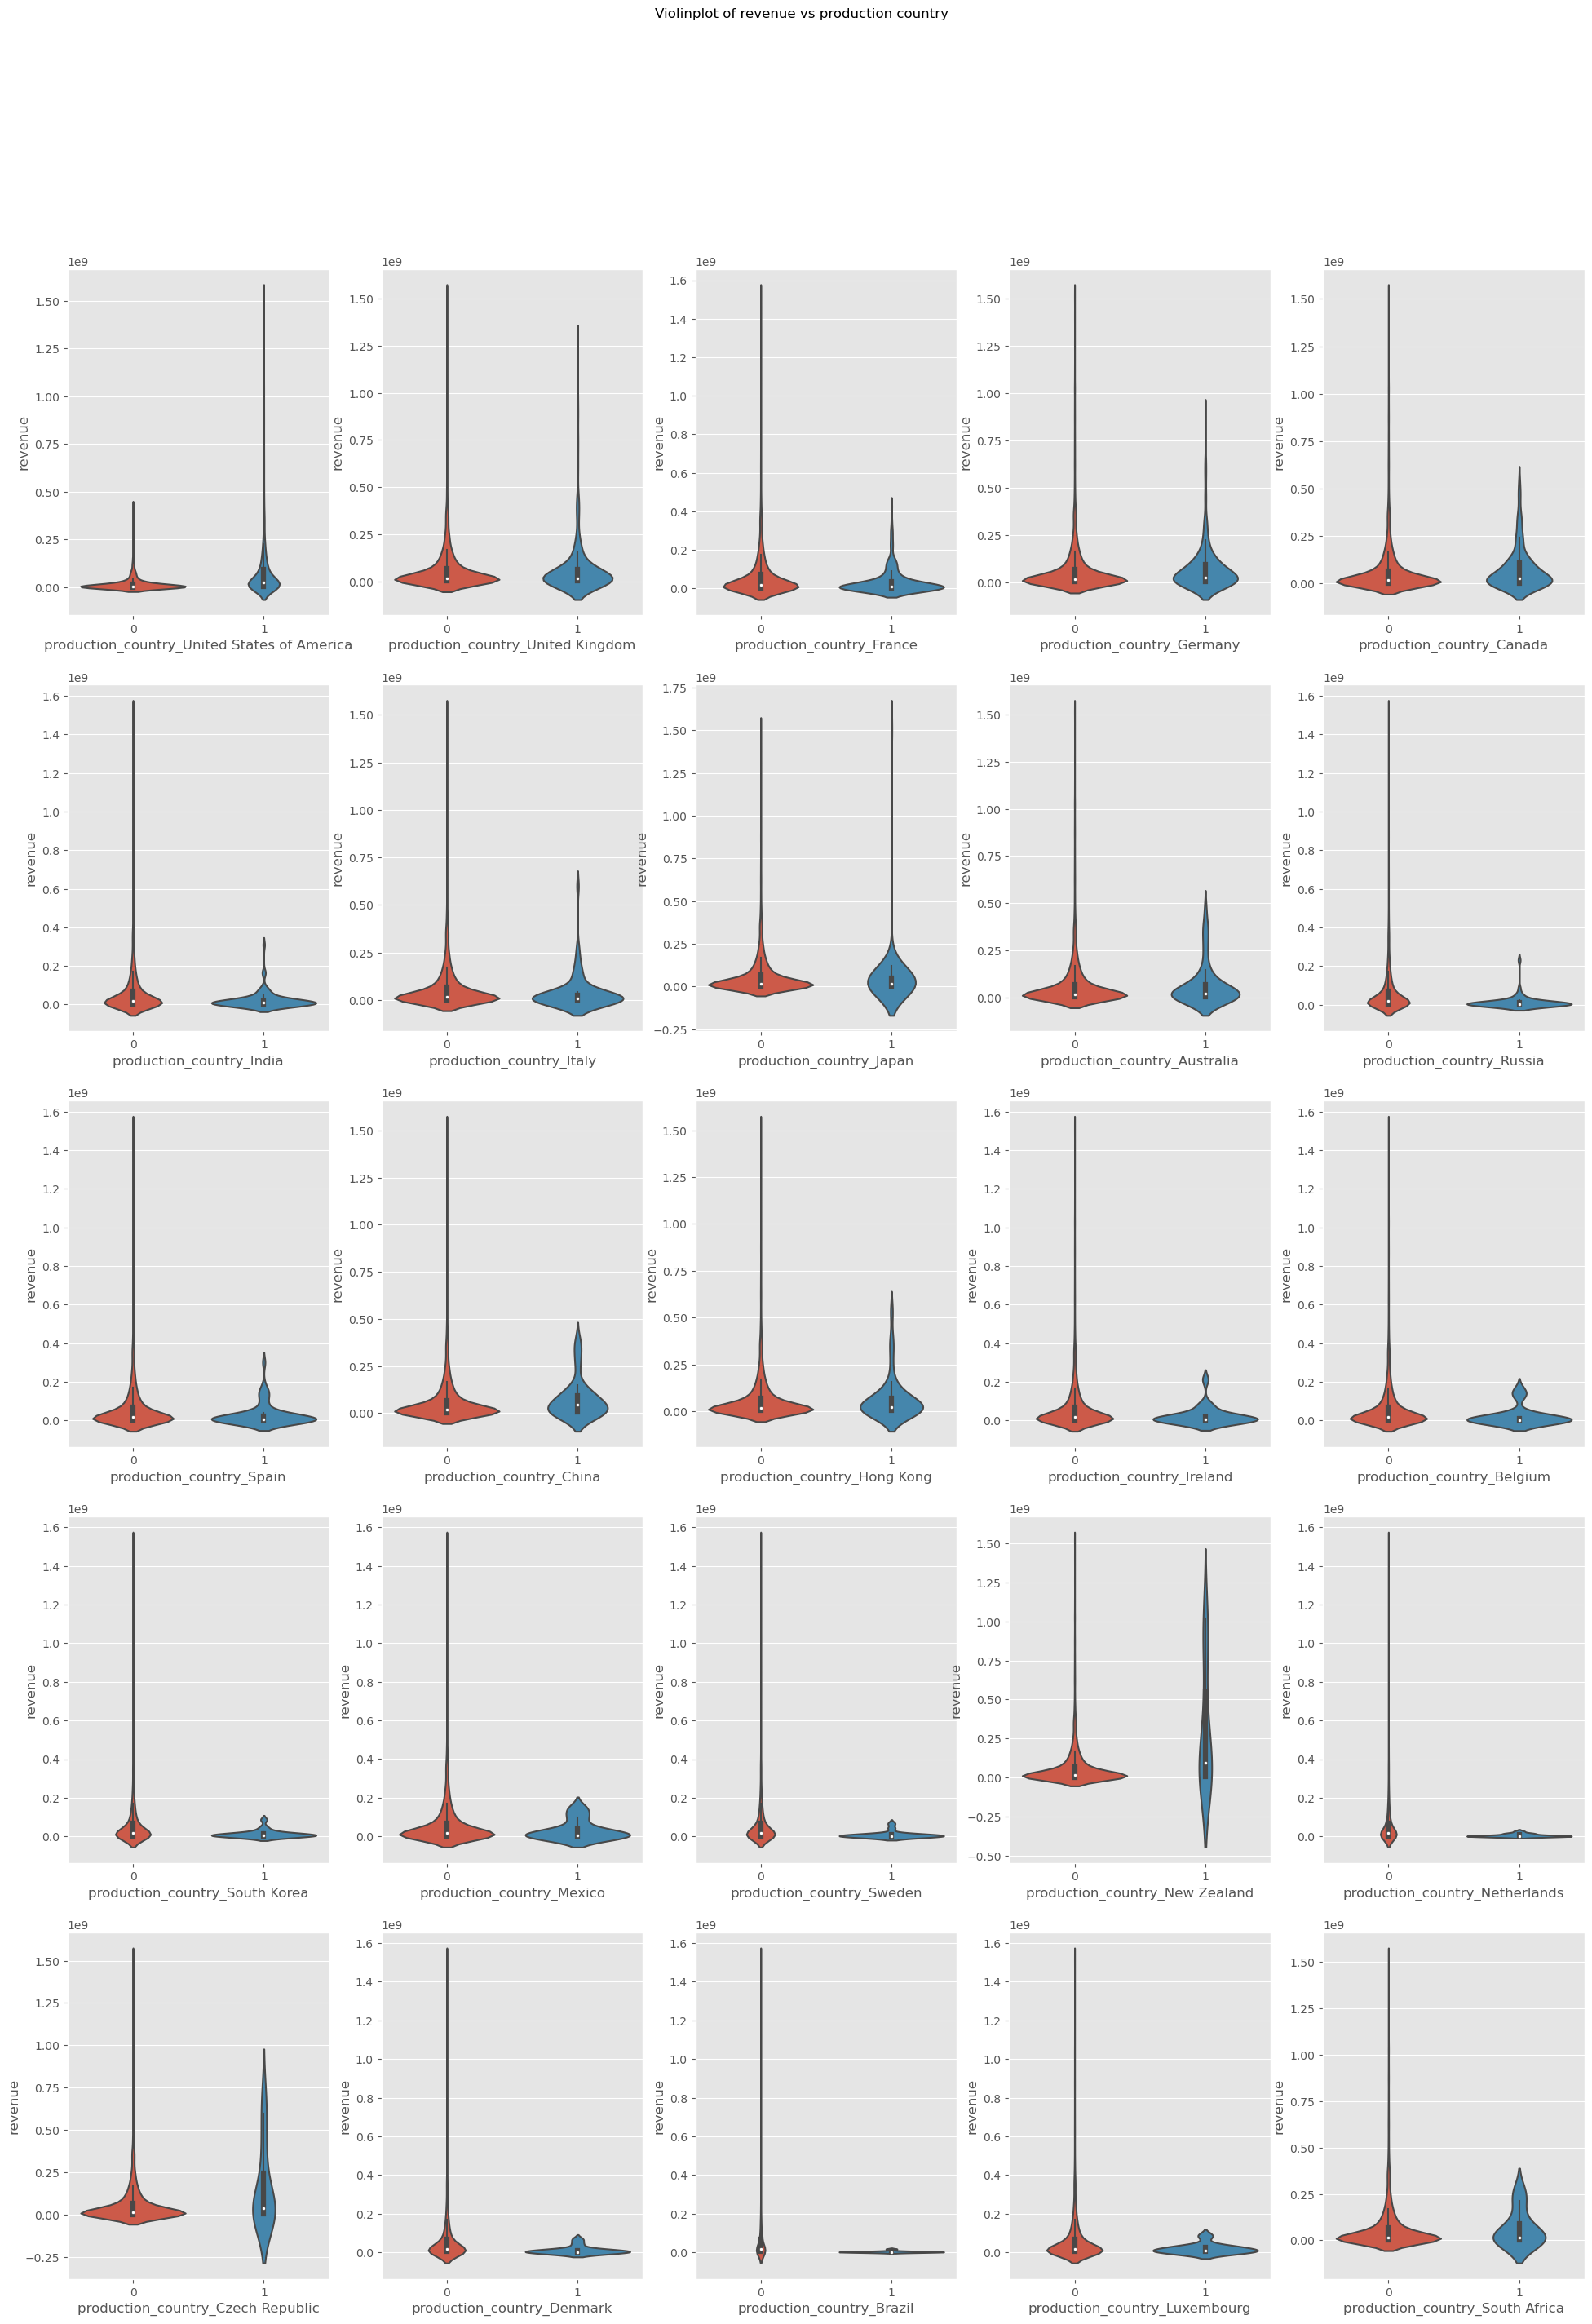

In [152]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Cast vs Revenue

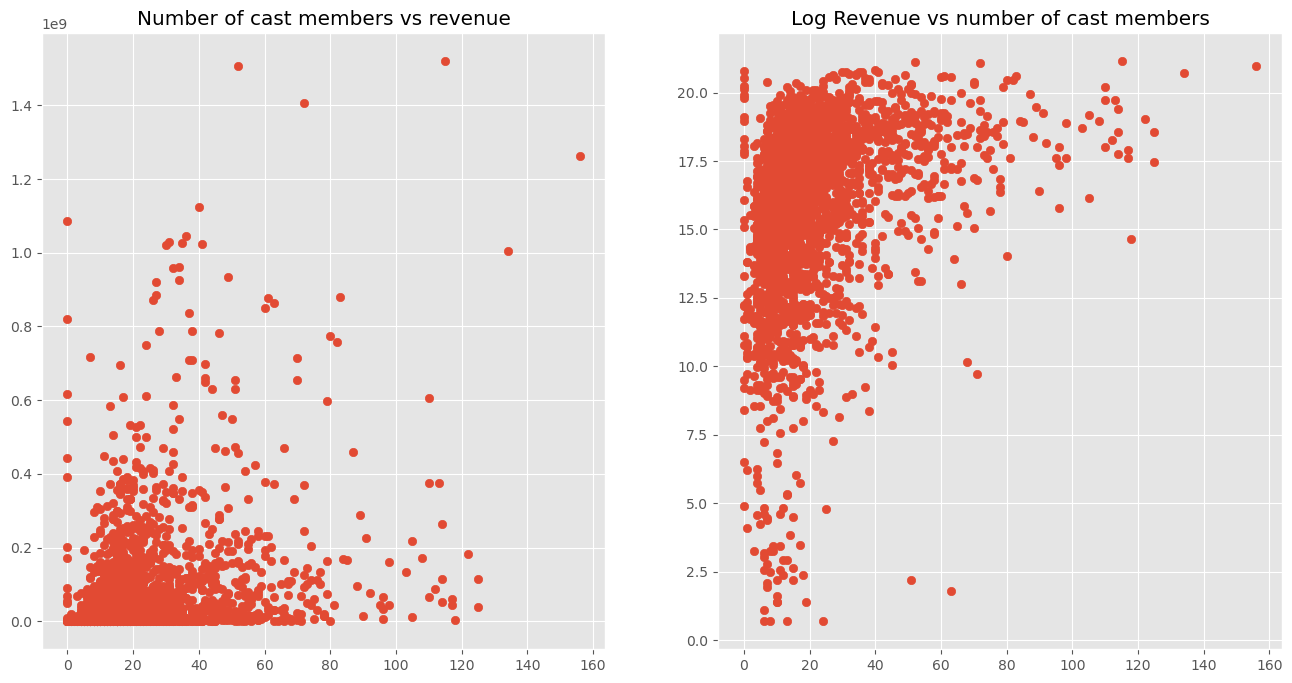

In [153]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

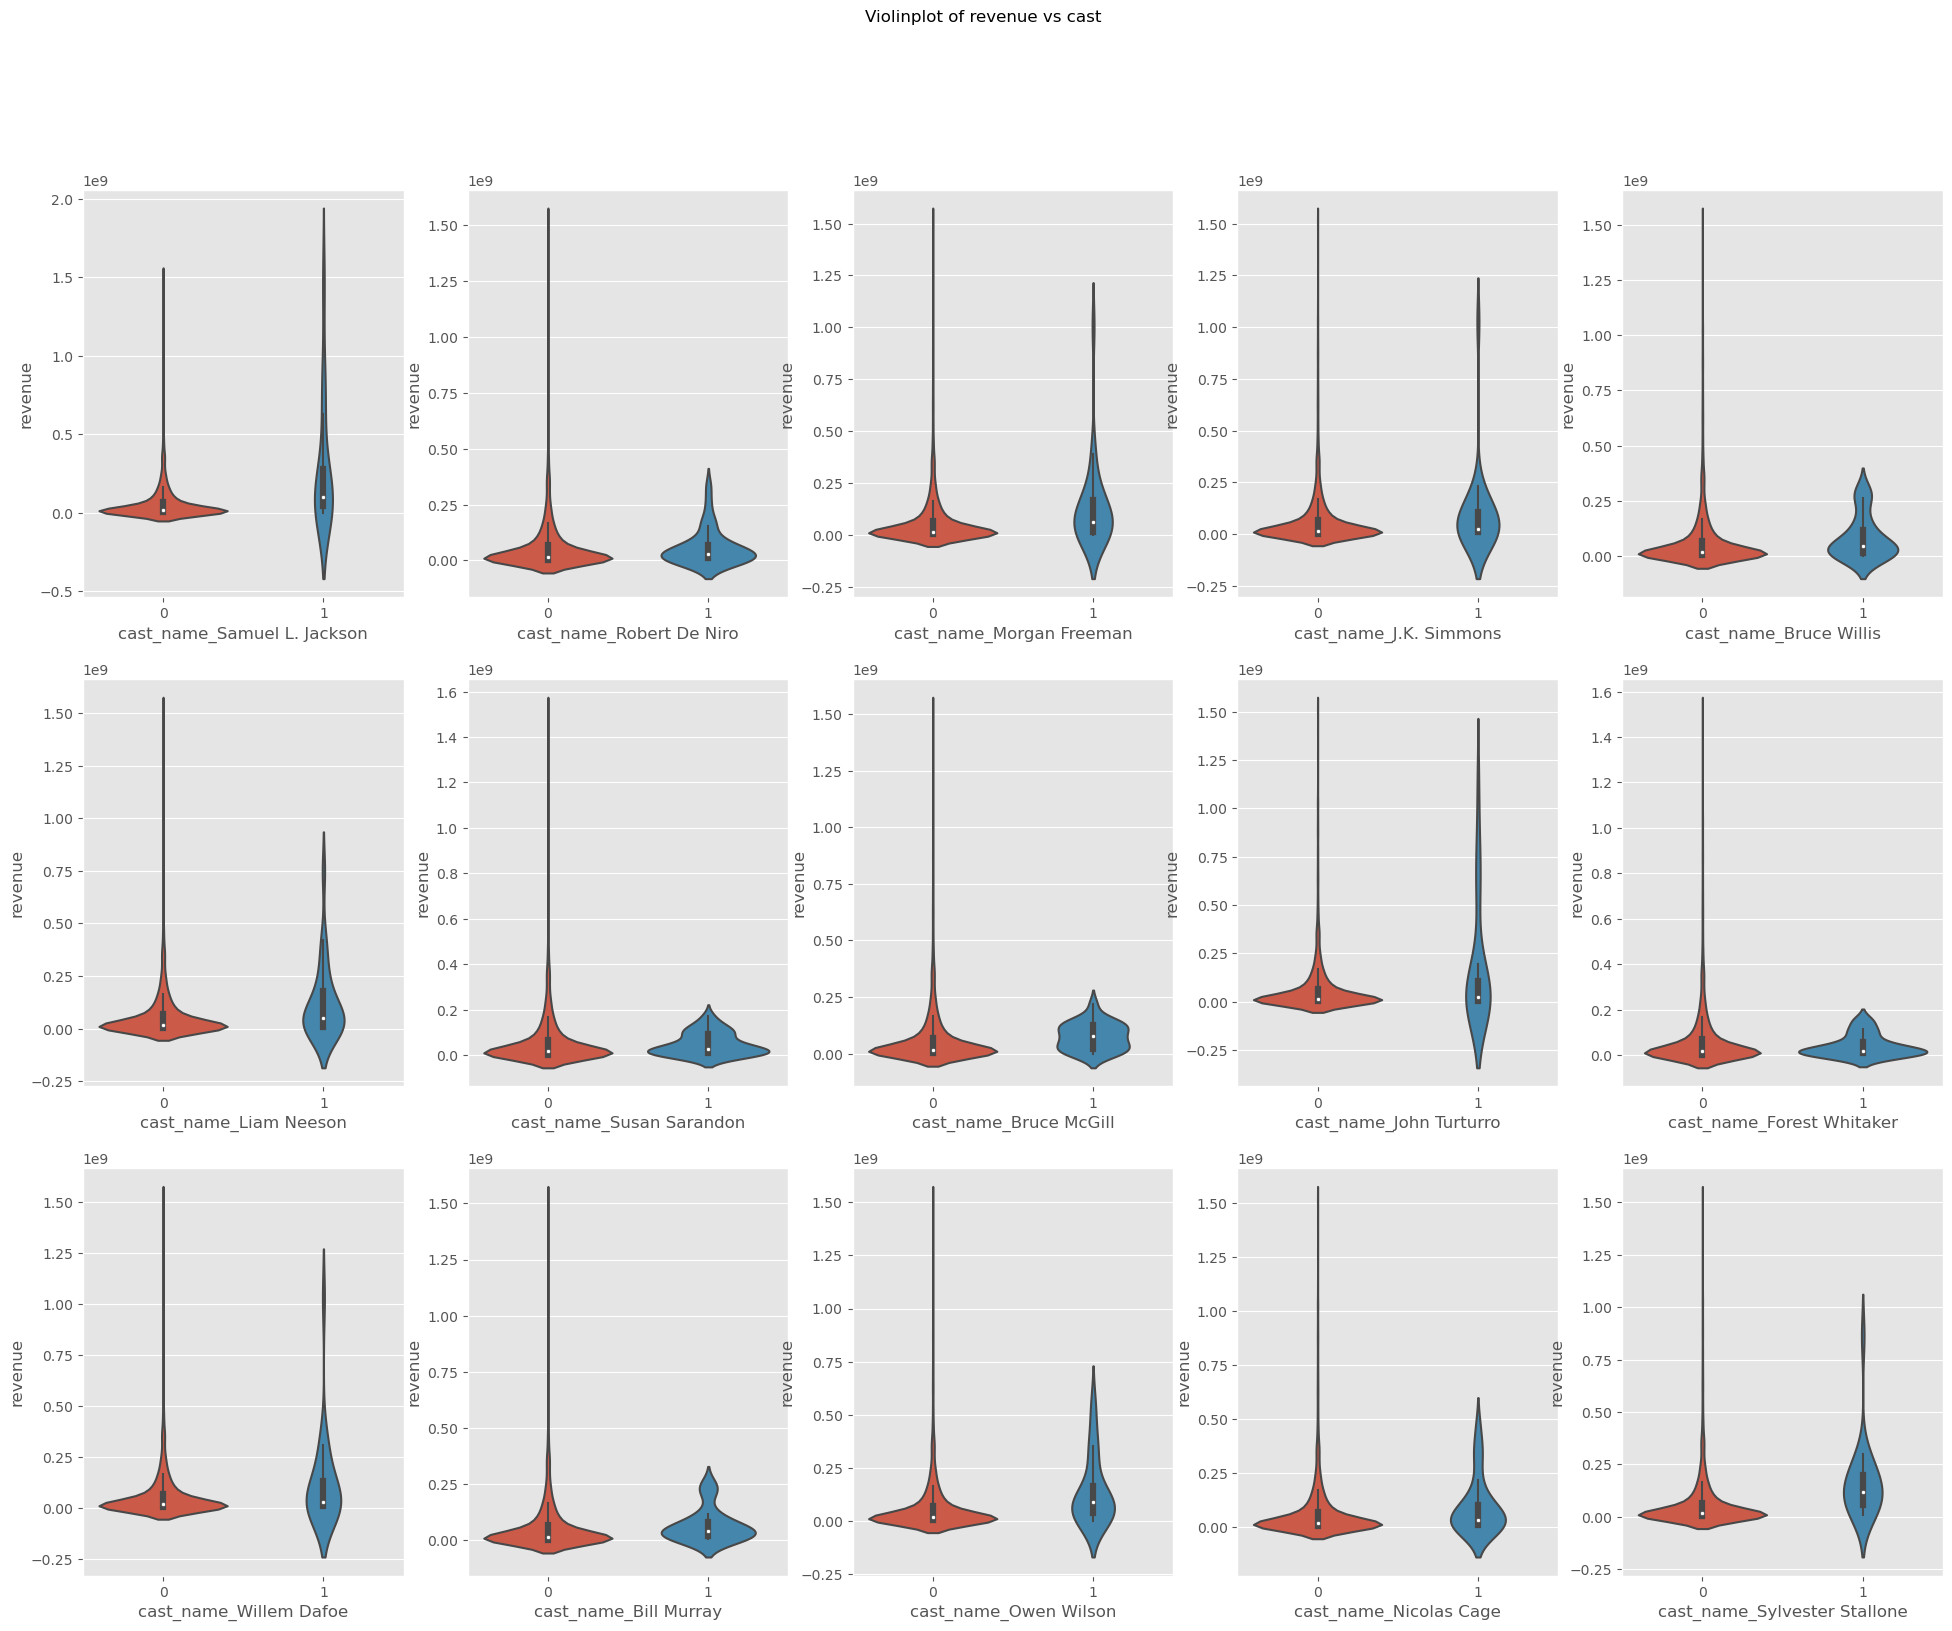

In [154]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

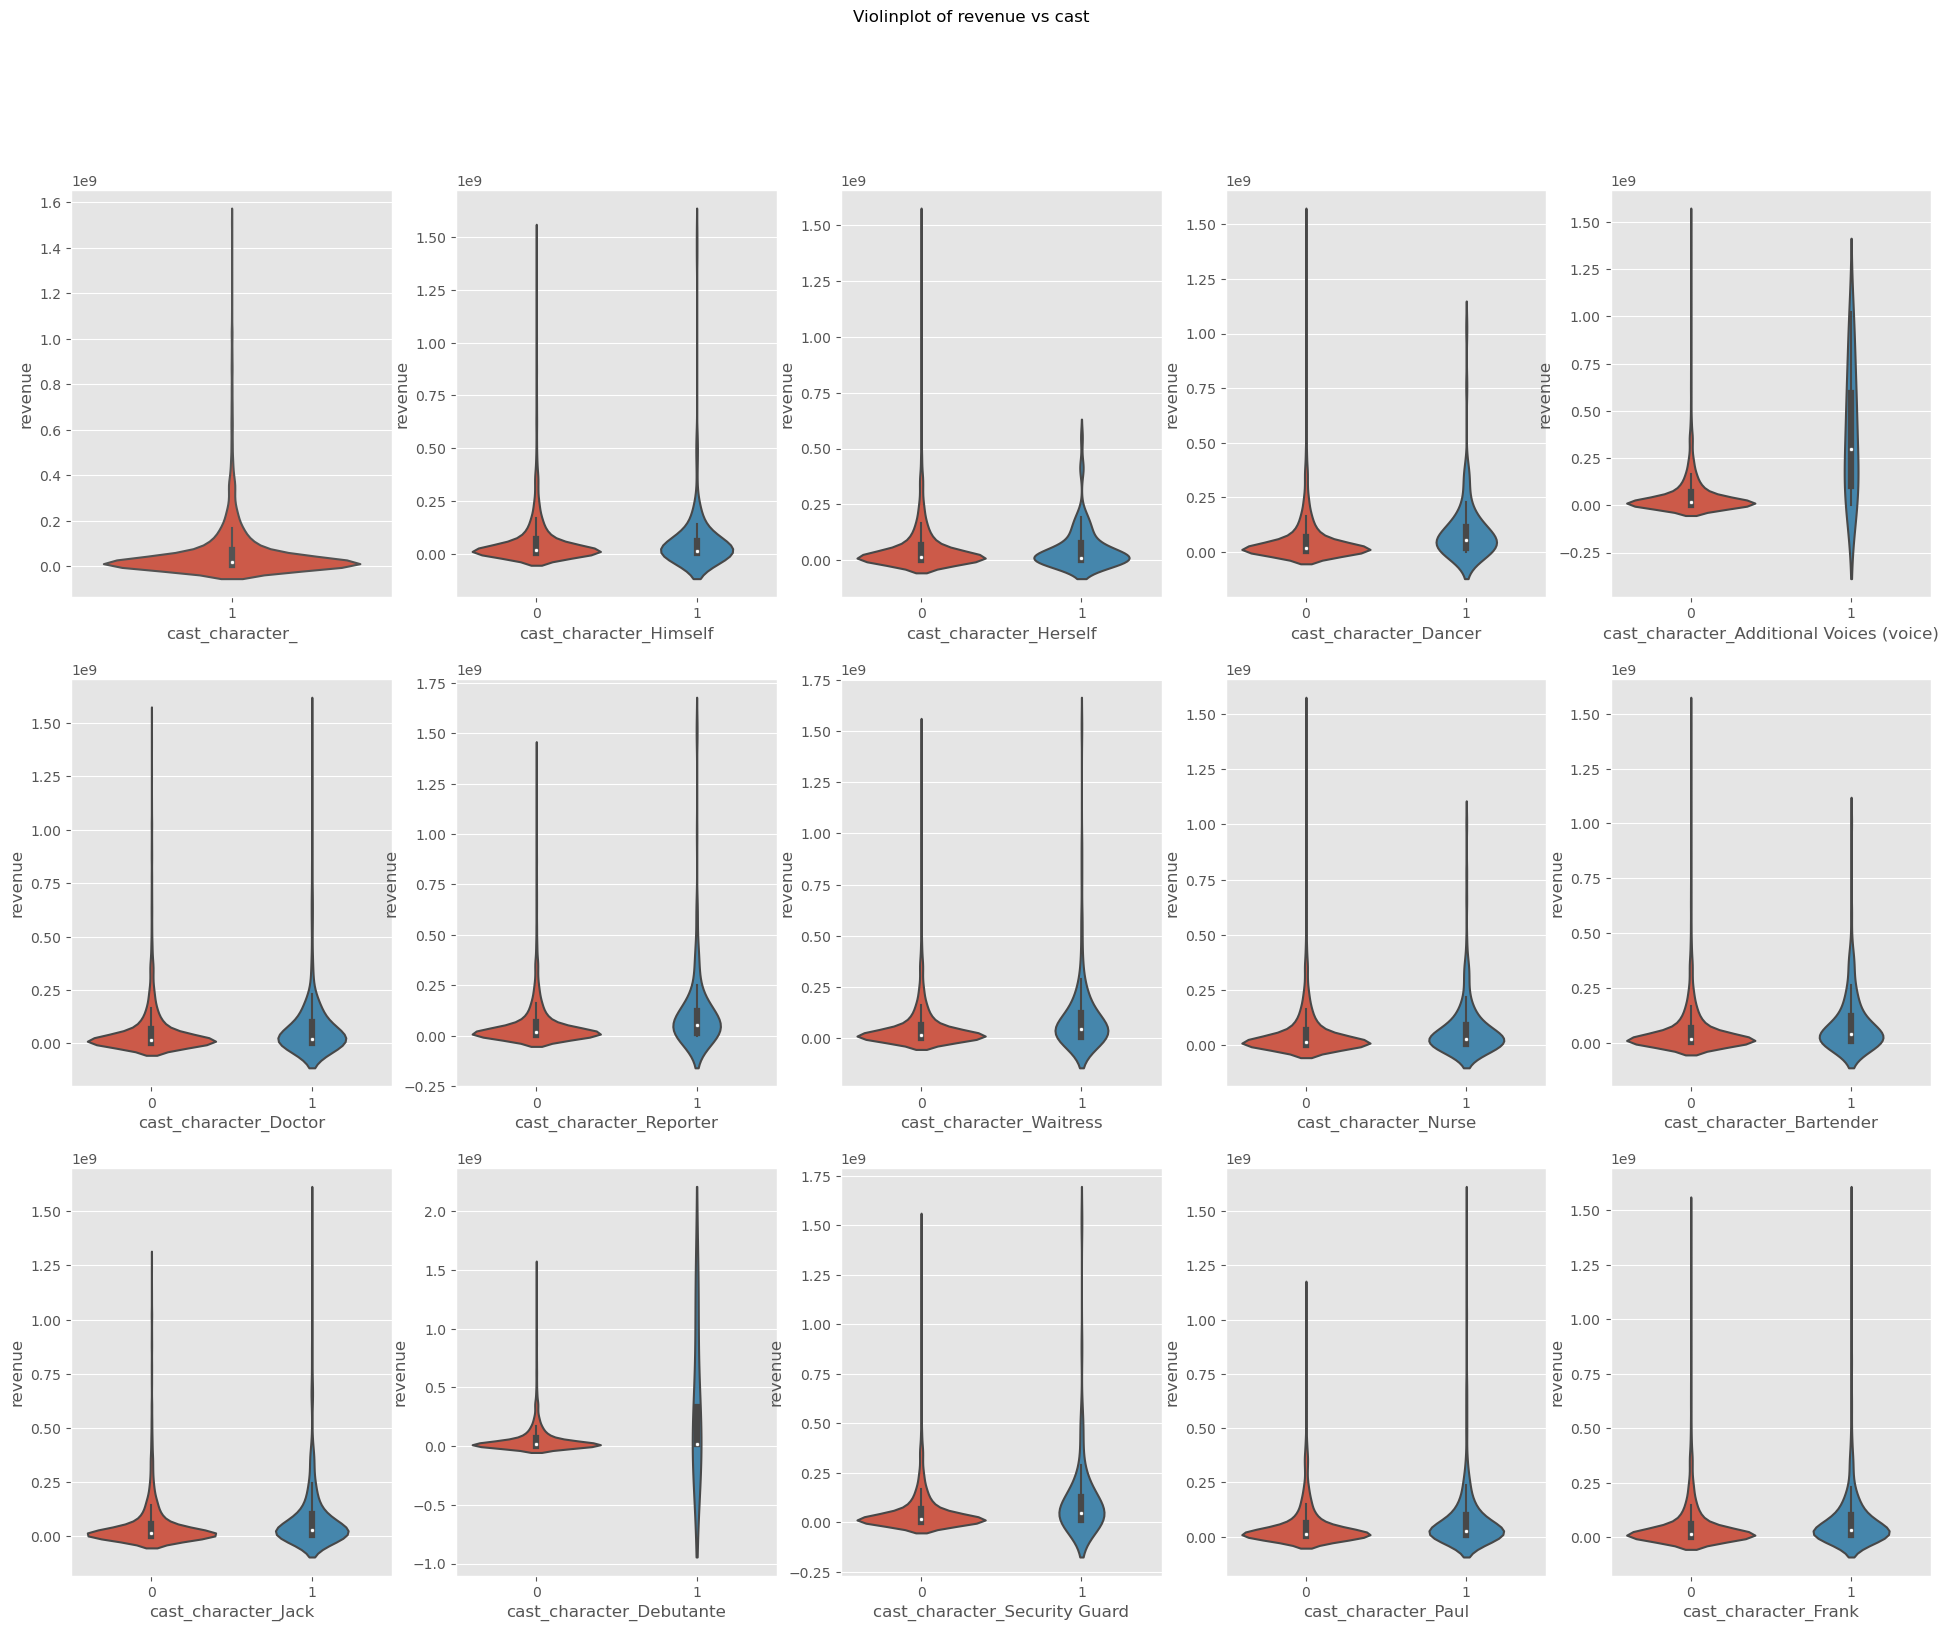

In [155]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Keywords vs Revenue

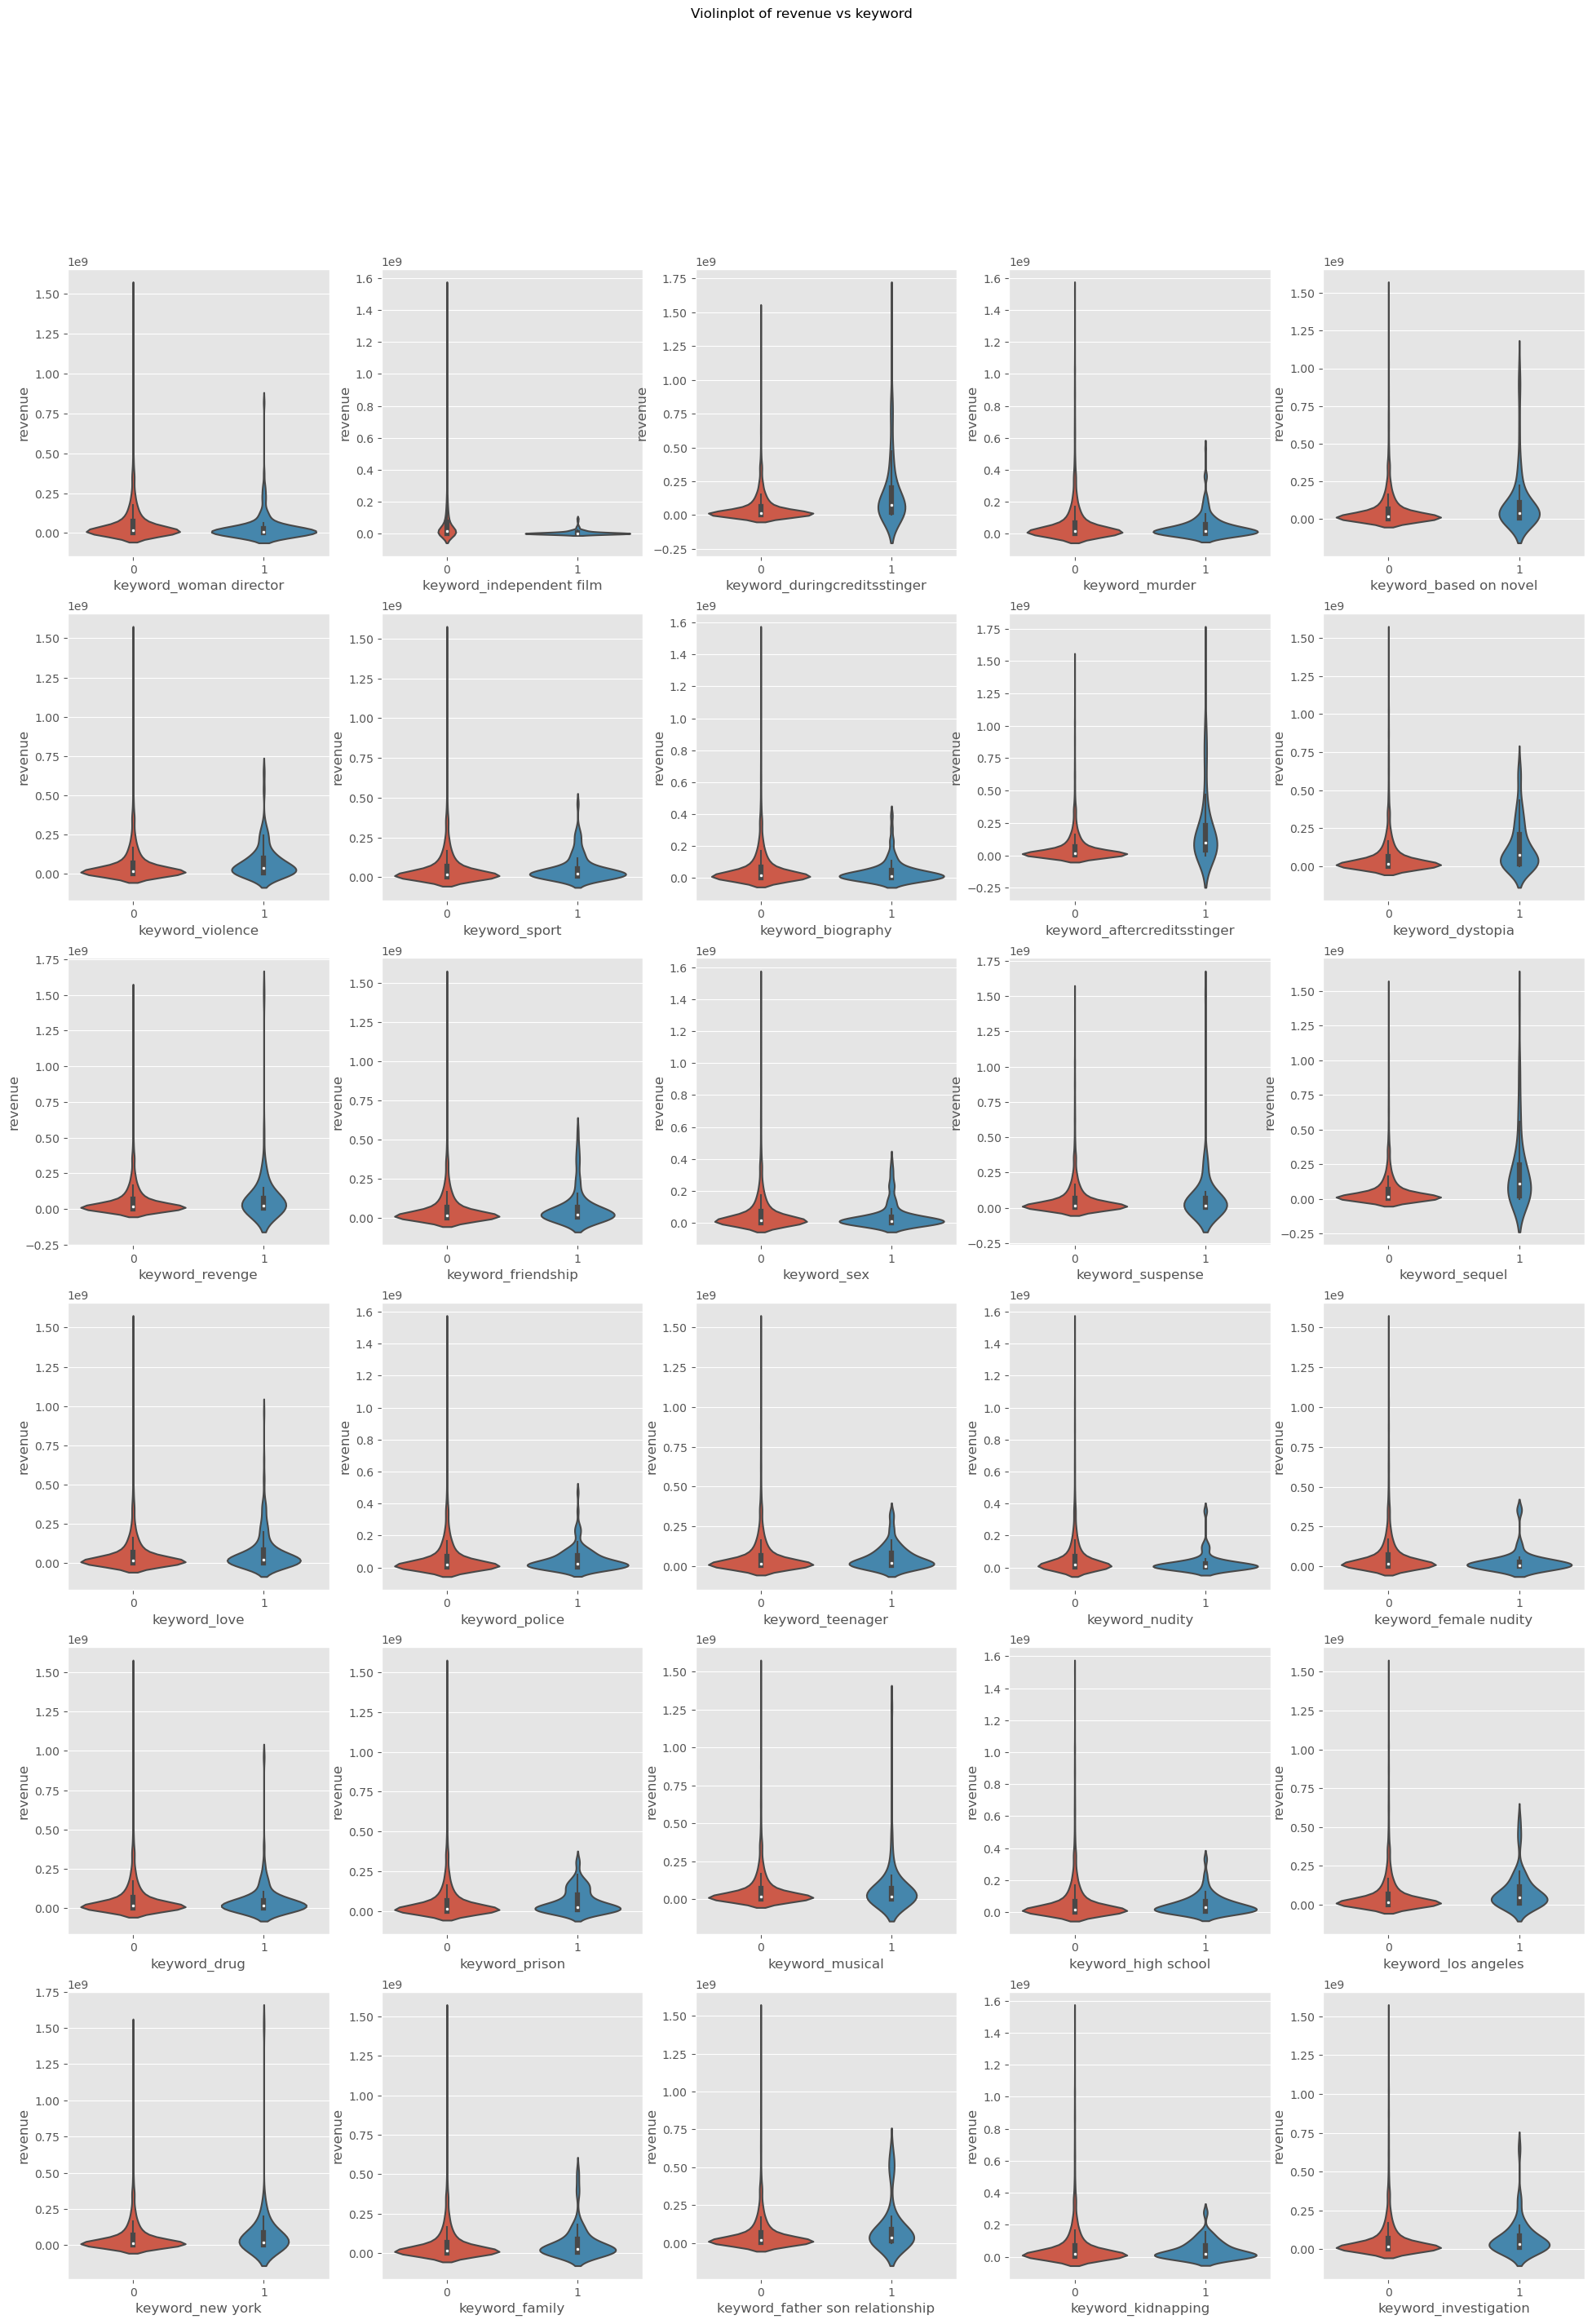

In [156]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Crew vs Revenue

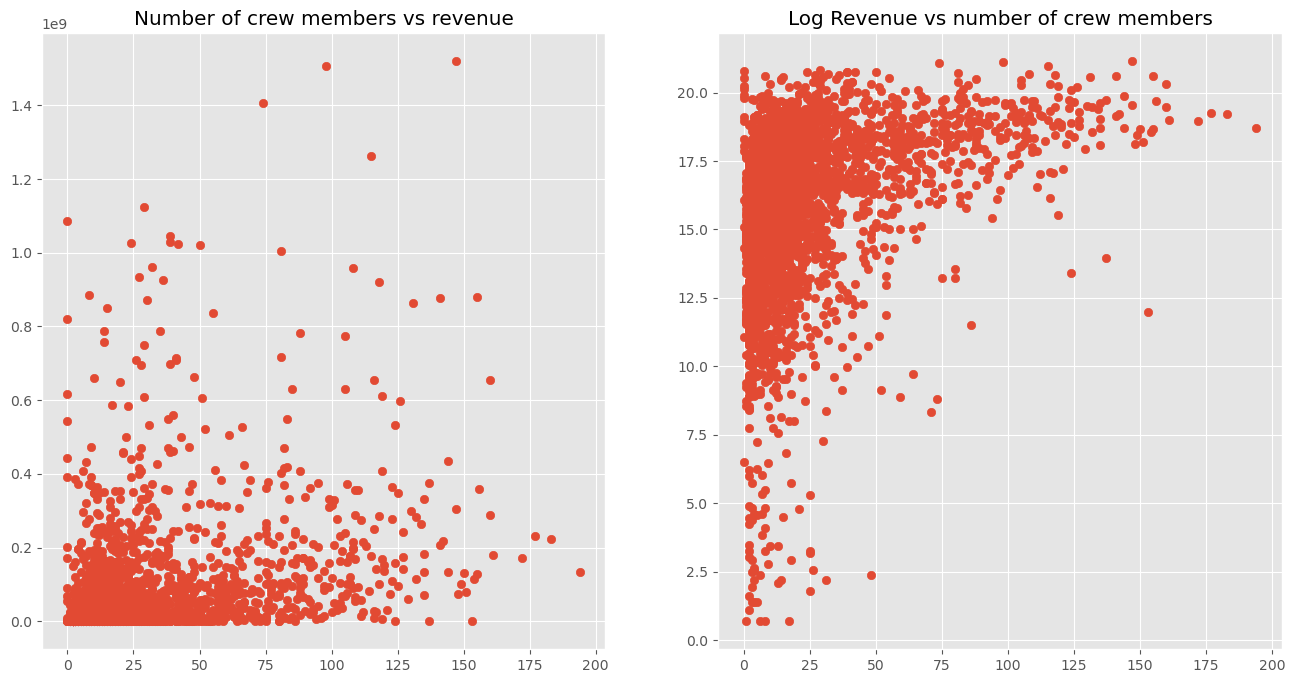

In [157]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

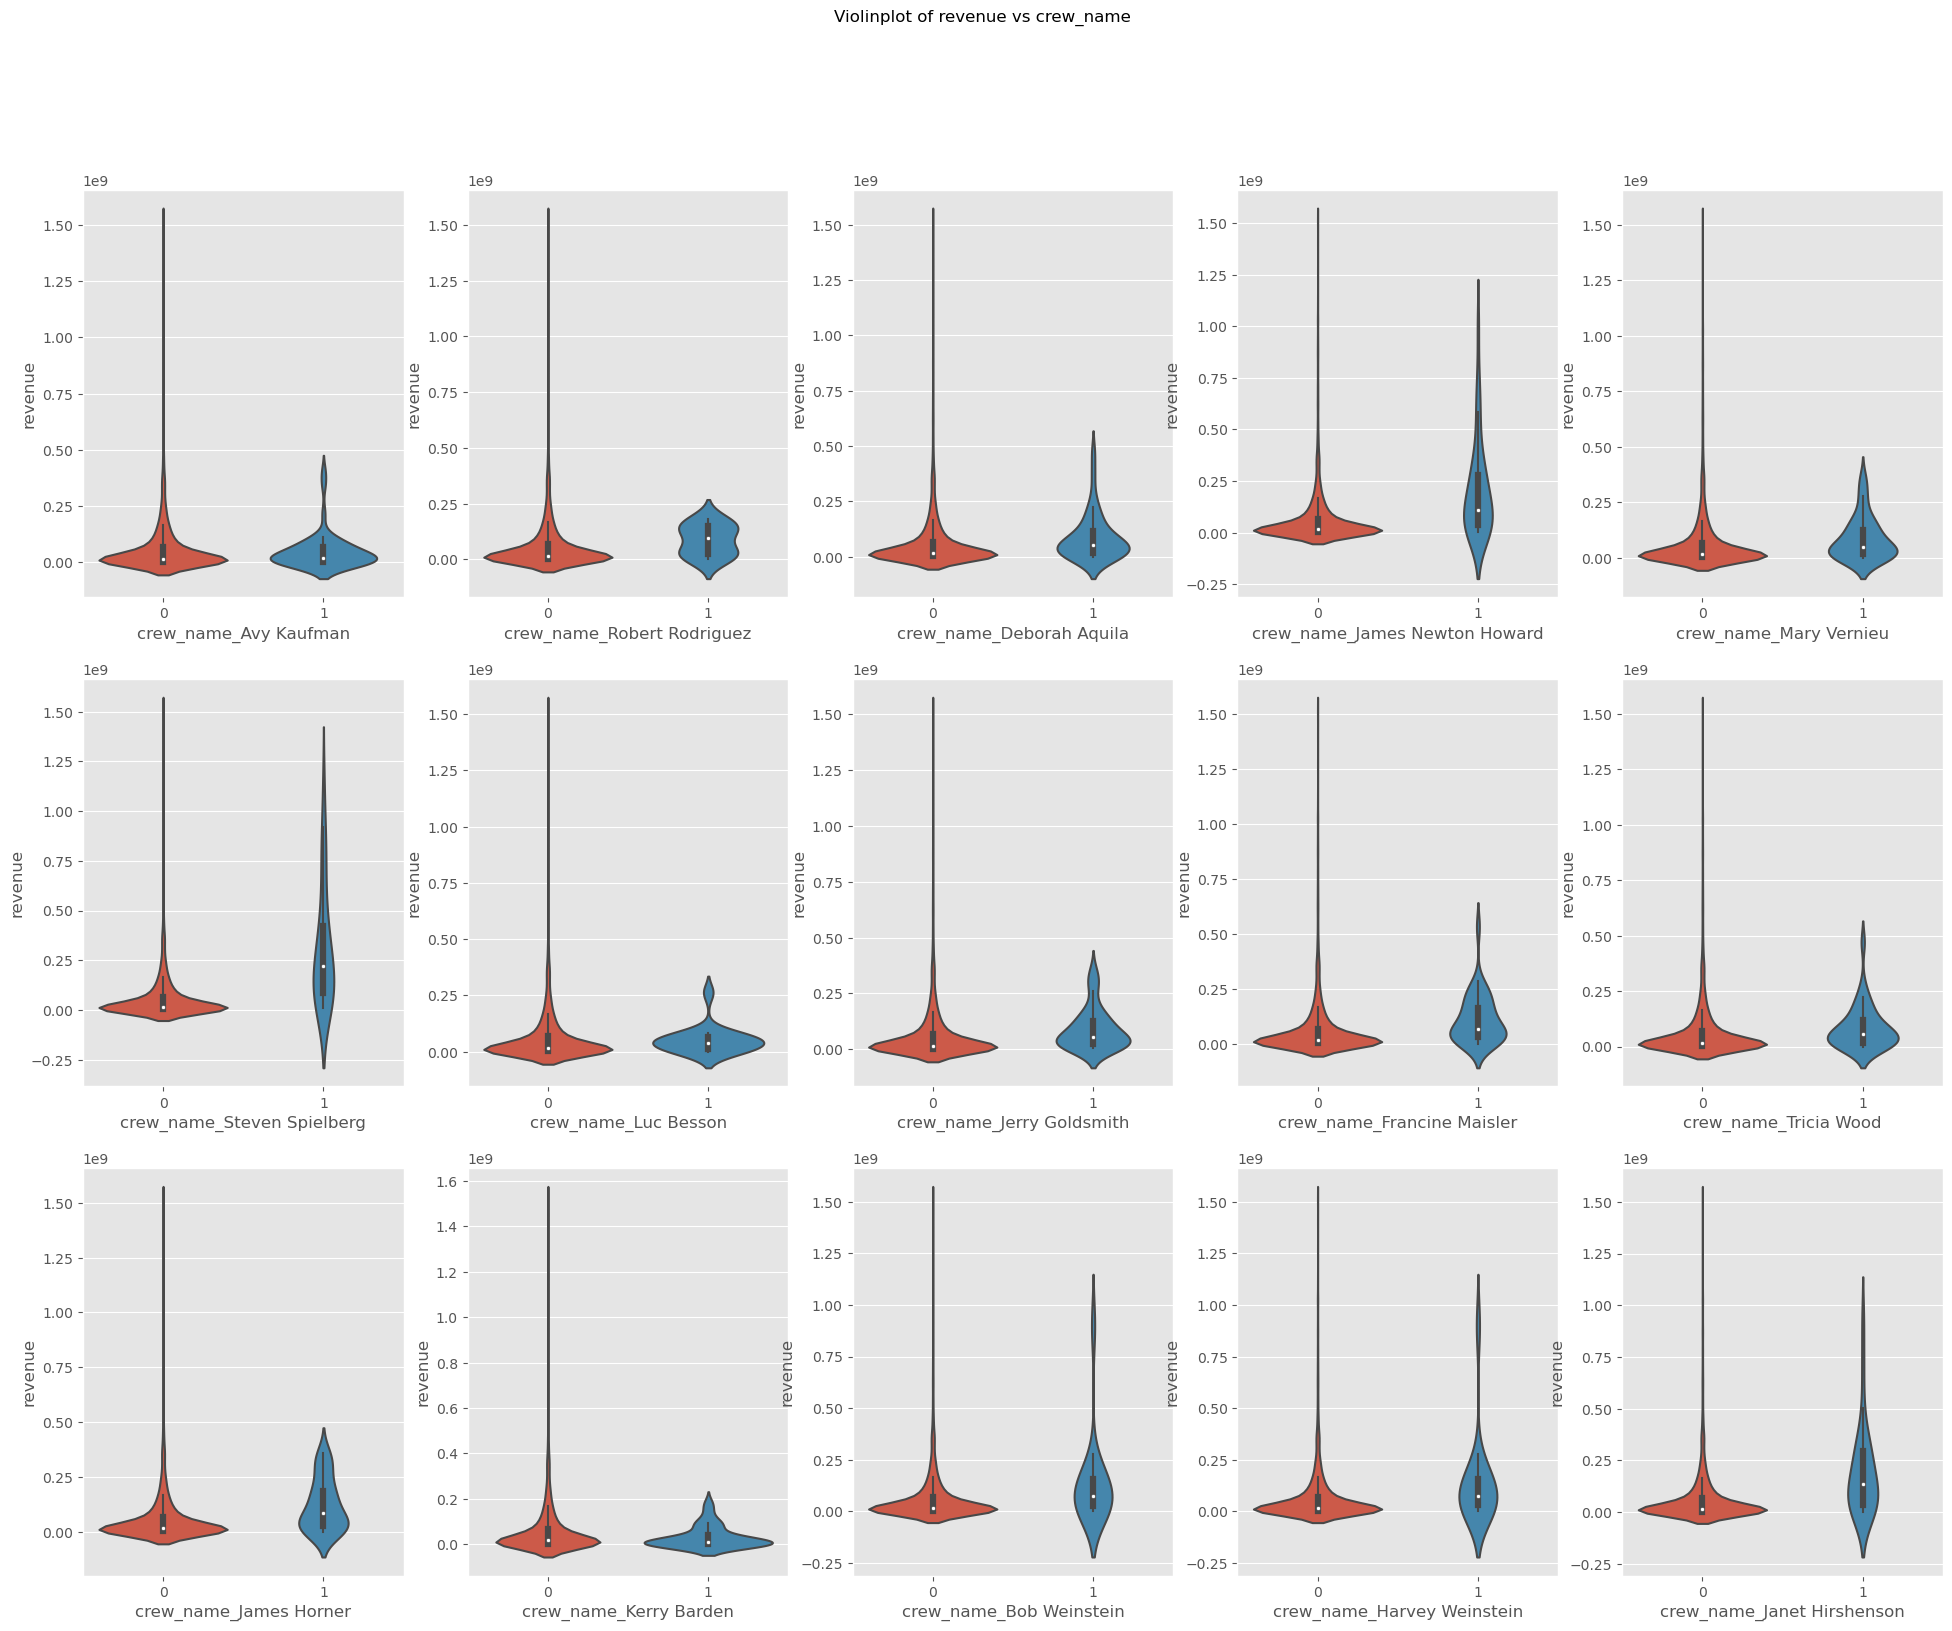

In [158]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_name')
for i, e in enumerate([col for col in train.columns if 'crew_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

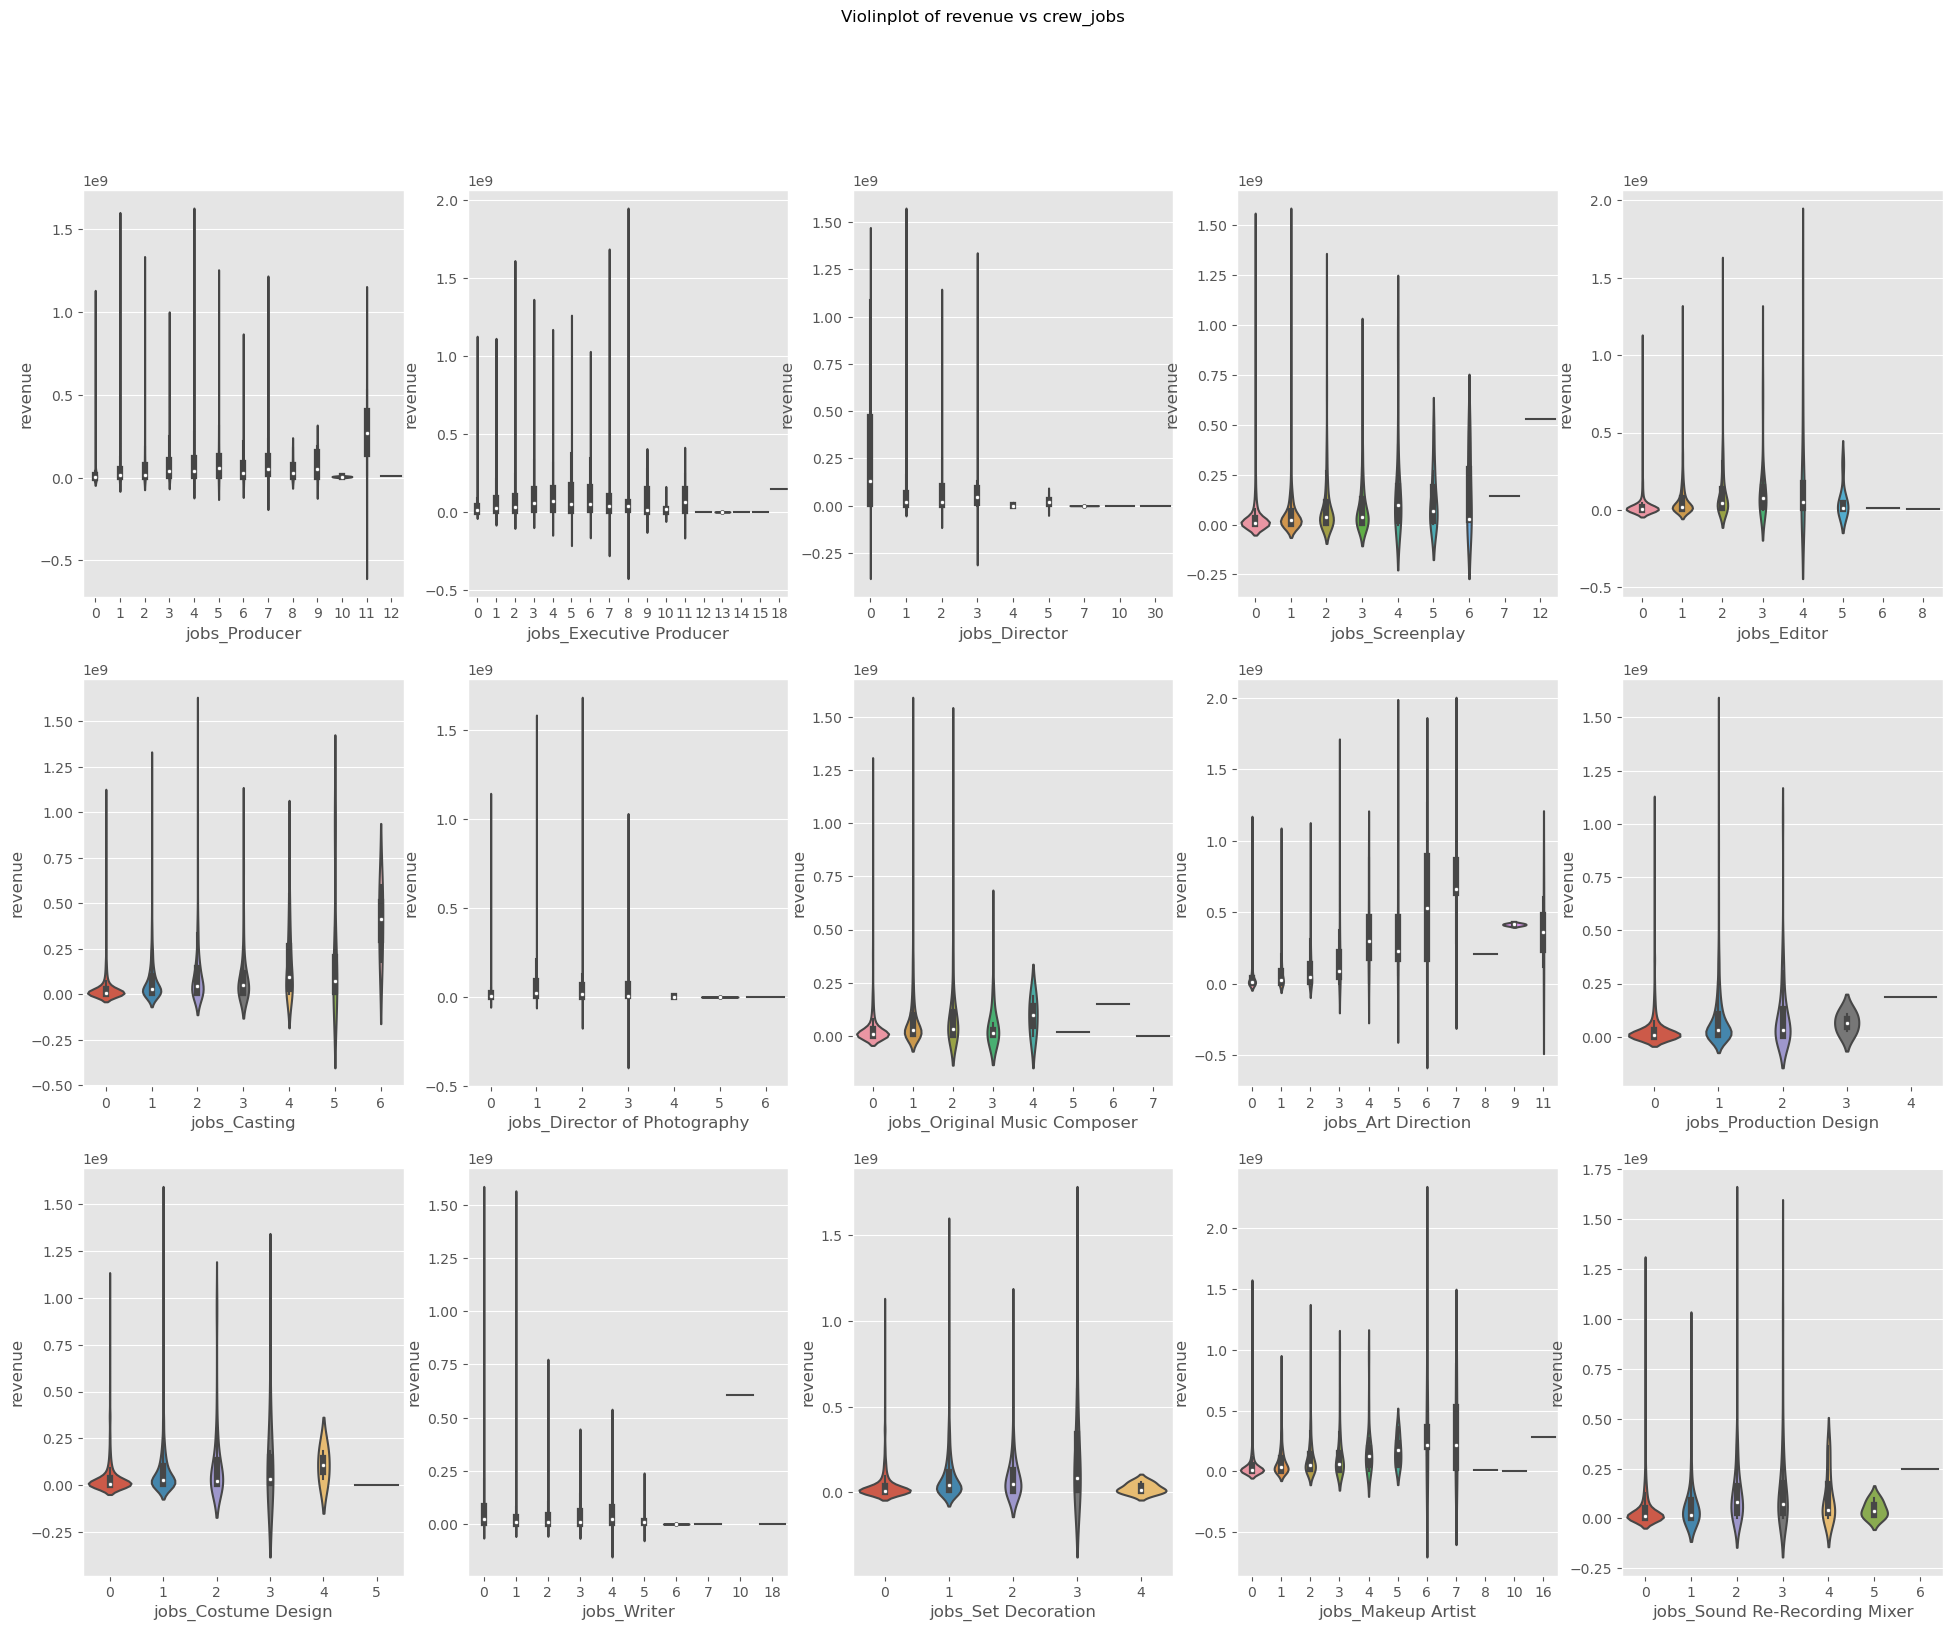

In [159]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

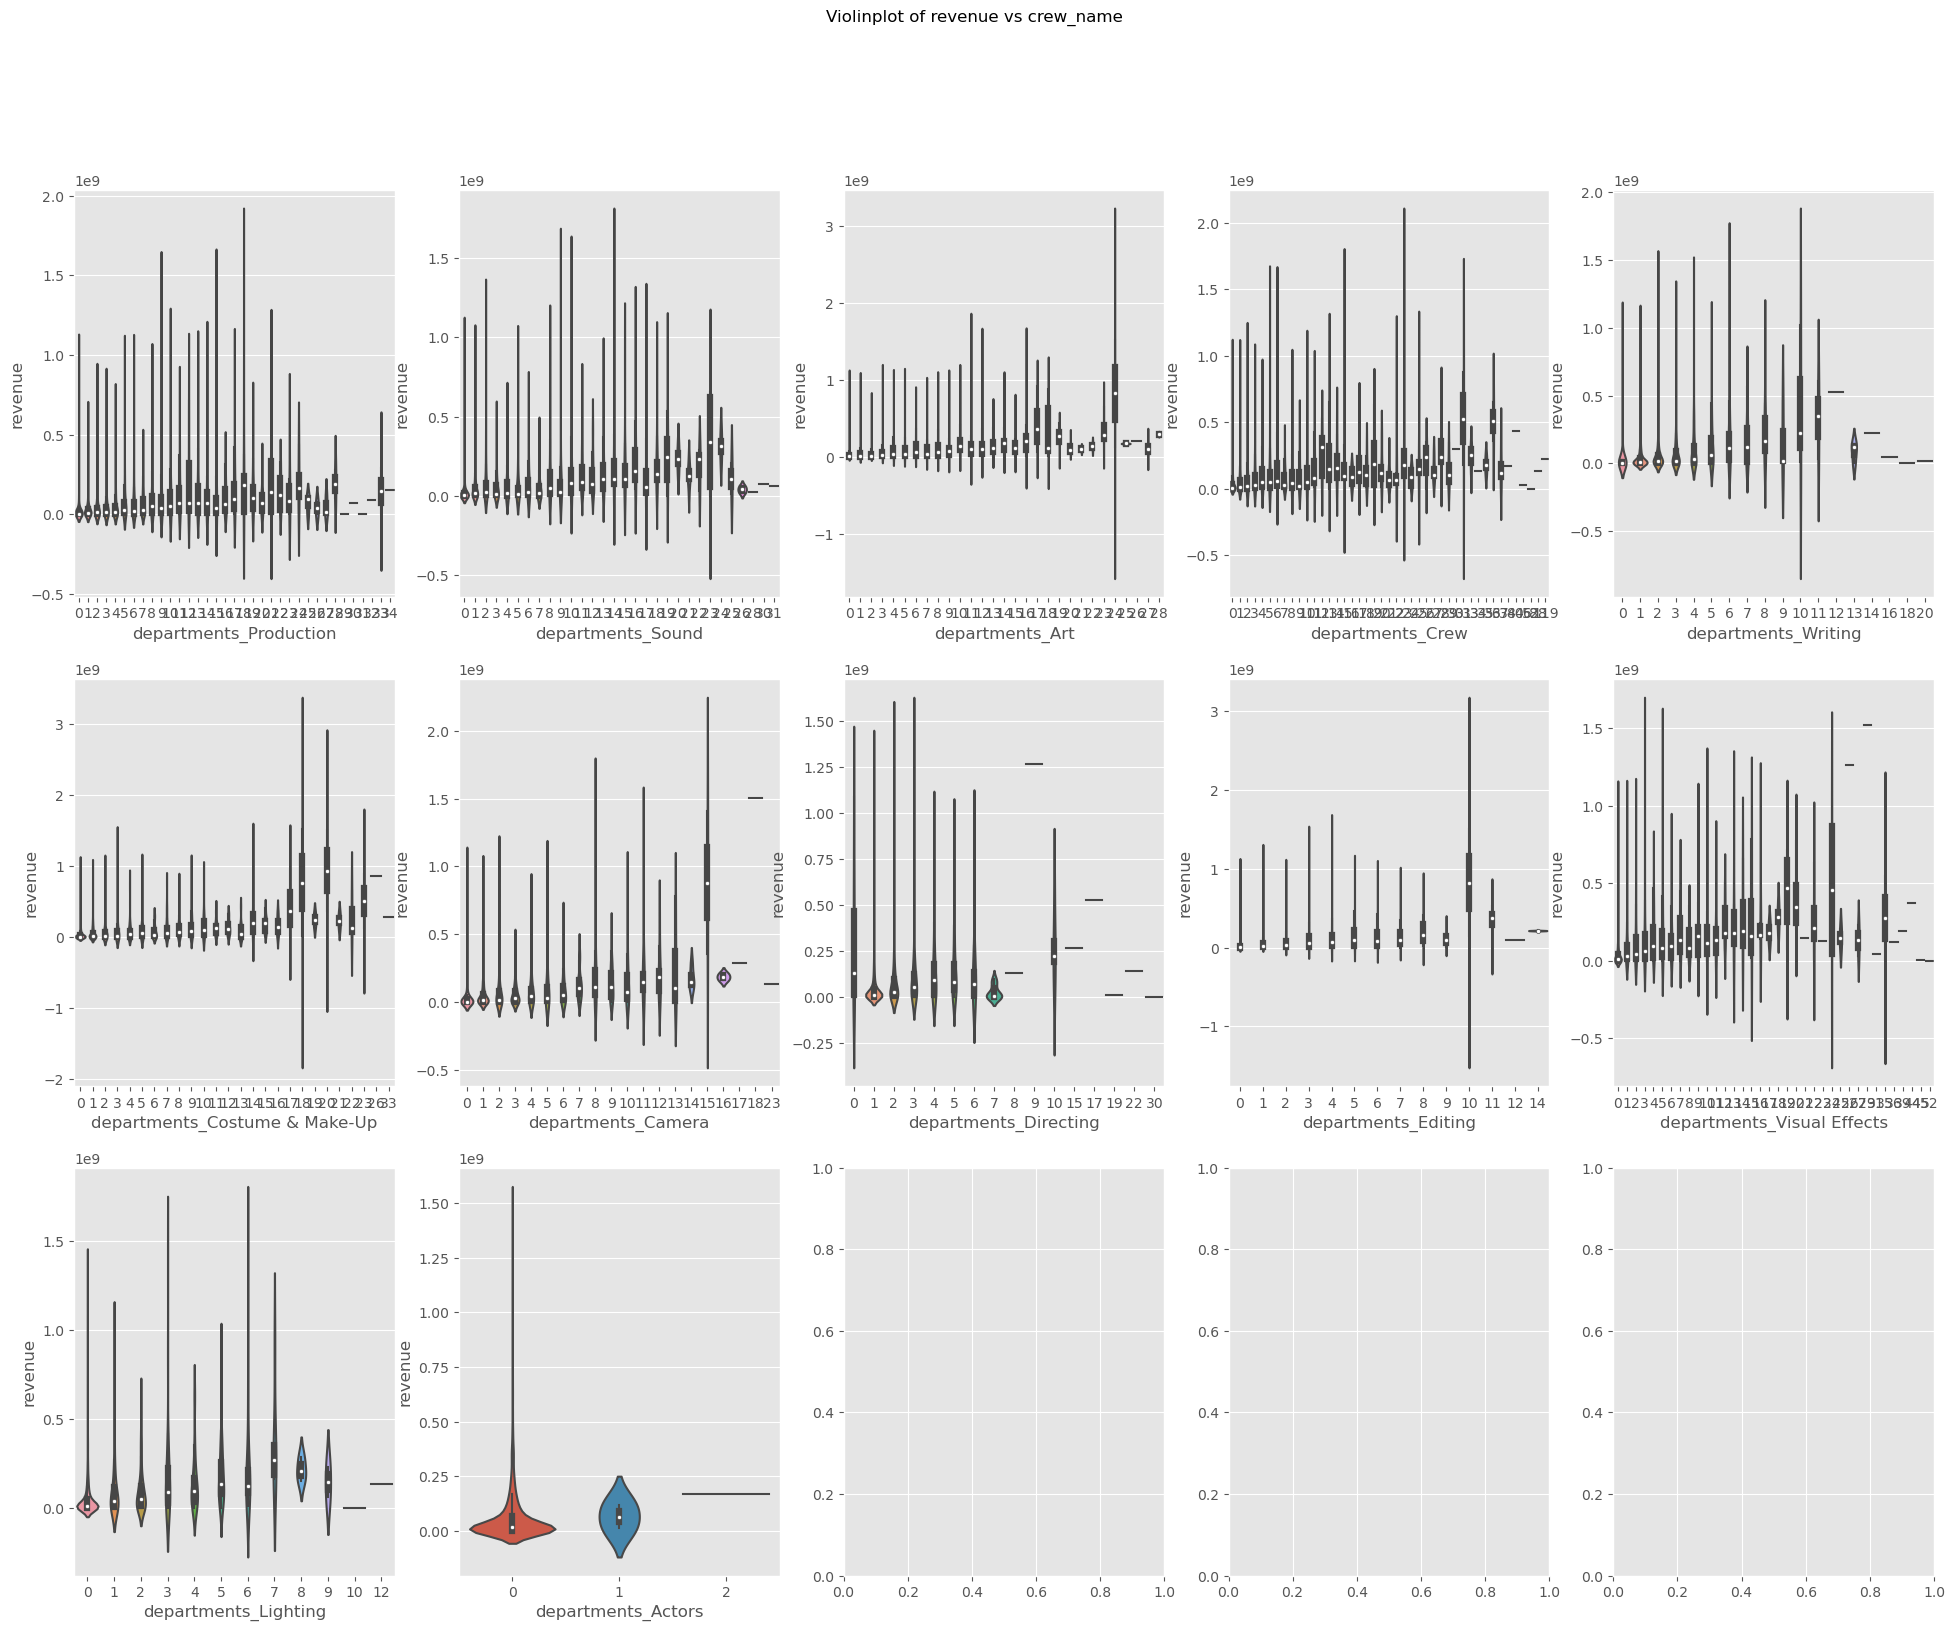

In [160]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_name')
for i, e in enumerate([col for col in train.columns if 'departments_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

# Machine Learning

In [161]:
#dropping the columns that do not have any correlation with revenue
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [162]:
#dropping the columns that only have a single unique value
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

language_
cast_character_


In [163]:
#converting 'original_language', 'collection_name', 'all_genres' columns into integers
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [164]:
#creating 2 new columns len + col (stores length of text in columns) and words + col (stores number of words in text in columns)
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\2712656601.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\2712656601.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sreek\AppData\Local\Temp\ipykernel_10008\2712656601.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [165]:
# data fixes for certain movies
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [166]:
#X is the train dataframe with id and revenue dropped, y is a dataframe with just the log revenue column
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [168]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse')

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', feature_fraction=0.9, lambda_l1=0.2,
              learning_rate=0.01, max_depth=5, metric='rmse',
              min_data_in_leaf=20, n_estimators=20000, n_jobs=-1, nthread=4,
              num_leaves=30, objective='regression', verbosity=-1)

In [169]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

In [170]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [175]:
def train_model_lgb(X, X_test, y, params=None, folds=None, plot_feature_importance=False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())

        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model = lgb.LGBMRegressor(**params, n_estimators=20000, n_jobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse')

        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration_)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        oof[valid_index] = y_pred_valid
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        prediction += y_pred

        if plot_feature_importance:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    if plot_feature_importance:
        feature_importance["importance"] /= folds.n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LGB Features (avg over folds)')

        return oof, prediction, feature_importance

    return oof, prediction

Fold 0 started at Wed Apr 24 00:16:57 2024
Fold 1 started at Wed Apr 24 00:17:31 2024
Fold 2 started at Wed Apr 24 00:18:24 2024
Fold 3 started at Wed Apr 24 00:19:27 2024
Fold 4 started at Wed Apr 24 00:20:18 2024
Fold 5 started at Wed Apr 24 00:21:08 2024
Fold 6 started at Wed Apr 24 00:22:00 2024
Fold 7 started at Wed Apr 24 00:22:55 2024
Fold 8 started at Wed Apr 24 00:23:47 2024
Fold 9 started at Wed Apr 24 00:24:39 2024
CV mean score: 1.9424, std: 0.1936.


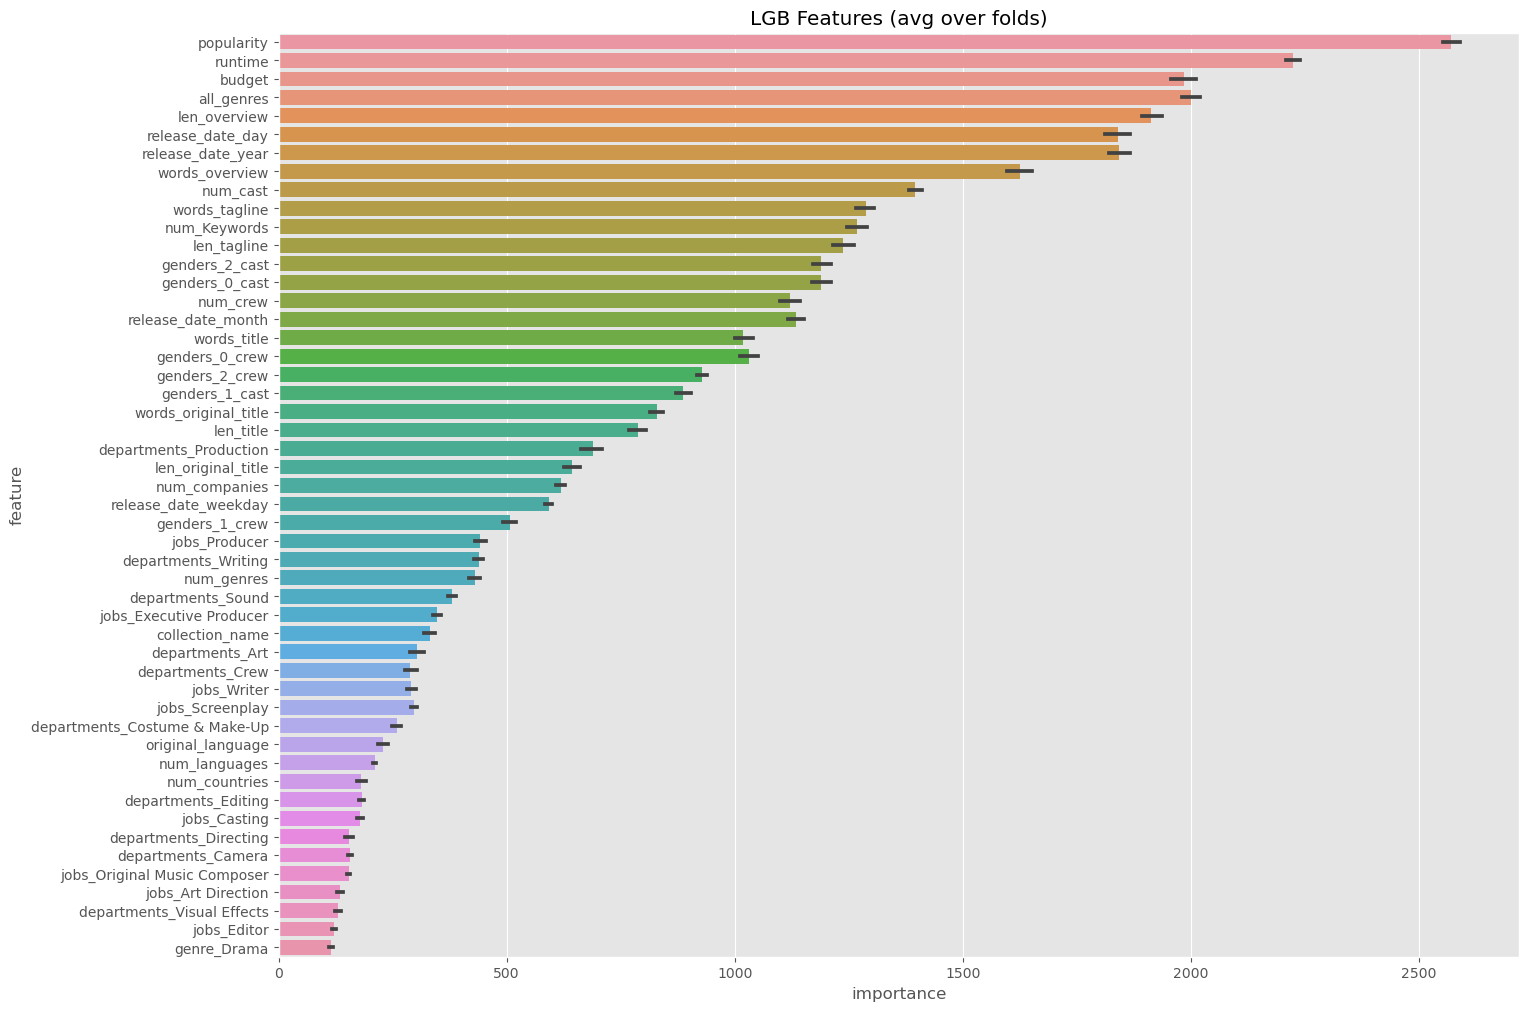

In [176]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model_lgb(X, X_test, y, params=params, folds=folds, plot_feature_importance=True)

Fold 0 started at Wed Apr 24 01:09:43 2024
Fold 1 started at Wed Apr 24 01:11:39 2024
Fold 2 started at Wed Apr 24 01:14:00 2024
Fold 3 started at Wed Apr 24 01:16:26 2024
Fold 4 started at Wed Apr 24 01:18:49 2024
Fold 5 started at Wed Apr 24 01:21:15 2024
Fold 6 started at Wed Apr 24 01:23:37 2024
Fold 7 started at Wed Apr 24 01:26:08 2024
Fold 8 started at Wed Apr 24 01:28:28 2024
Fold 9 started at Wed Apr 24 01:30:52 2024
CV mean score: 1.9162, std: 0.1780.


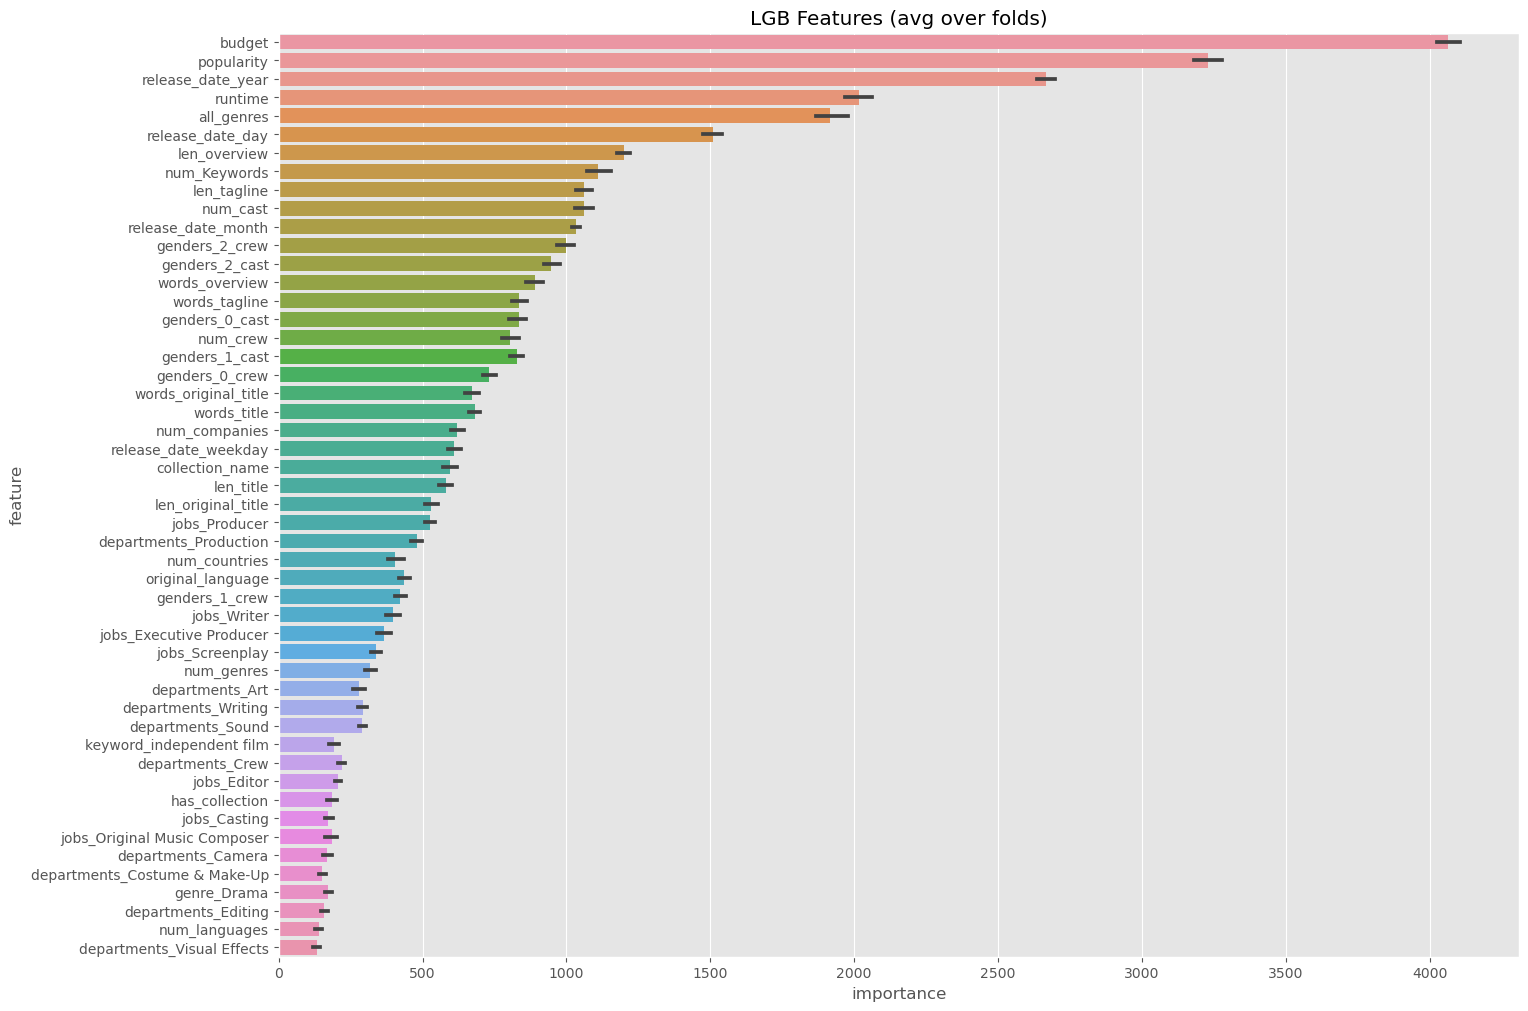

In [179]:
params = {
    'num_leaves': 30,
    'min_data_in_leaf': 10,
    'objective': 'regression',
    'max_depth': 5,
    'learning_rate': 0.01,
    "boosting": "dart",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "verbosity": -1,
    "drop_rate": 0.1,  # Default value is 0.1
    "max_drop": 50,    # Allows up to 50 trees to be dropped
    "skip_drop": 0.5,  # Default value, higher values might reduce variability
    "xgboost_dart_mode": False,
    "uniform_drop": False
}
oof_lgb, prediction_lgb, _ = train_model_lgb(X, X_test, y, params=params, folds=folds, plot_feature_importance=True)

Fold 0 started at Wed Apr 24 01:44:26 2024
Fold 1 started at Wed Apr 24 01:44:46 2024
Fold 2 started at Wed Apr 24 01:45:08 2024
Fold 3 started at Wed Apr 24 01:45:33 2024
Fold 4 started at Wed Apr 24 01:46:02 2024
Fold 5 started at Wed Apr 24 01:46:33 2024
Fold 6 started at Wed Apr 24 01:47:05 2024
Fold 7 started at Wed Apr 24 01:47:41 2024
Fold 8 started at Wed Apr 24 01:48:18 2024
Fold 9 started at Wed Apr 24 01:48:55 2024
CV mean score: 2.0016, std: 0.1902.


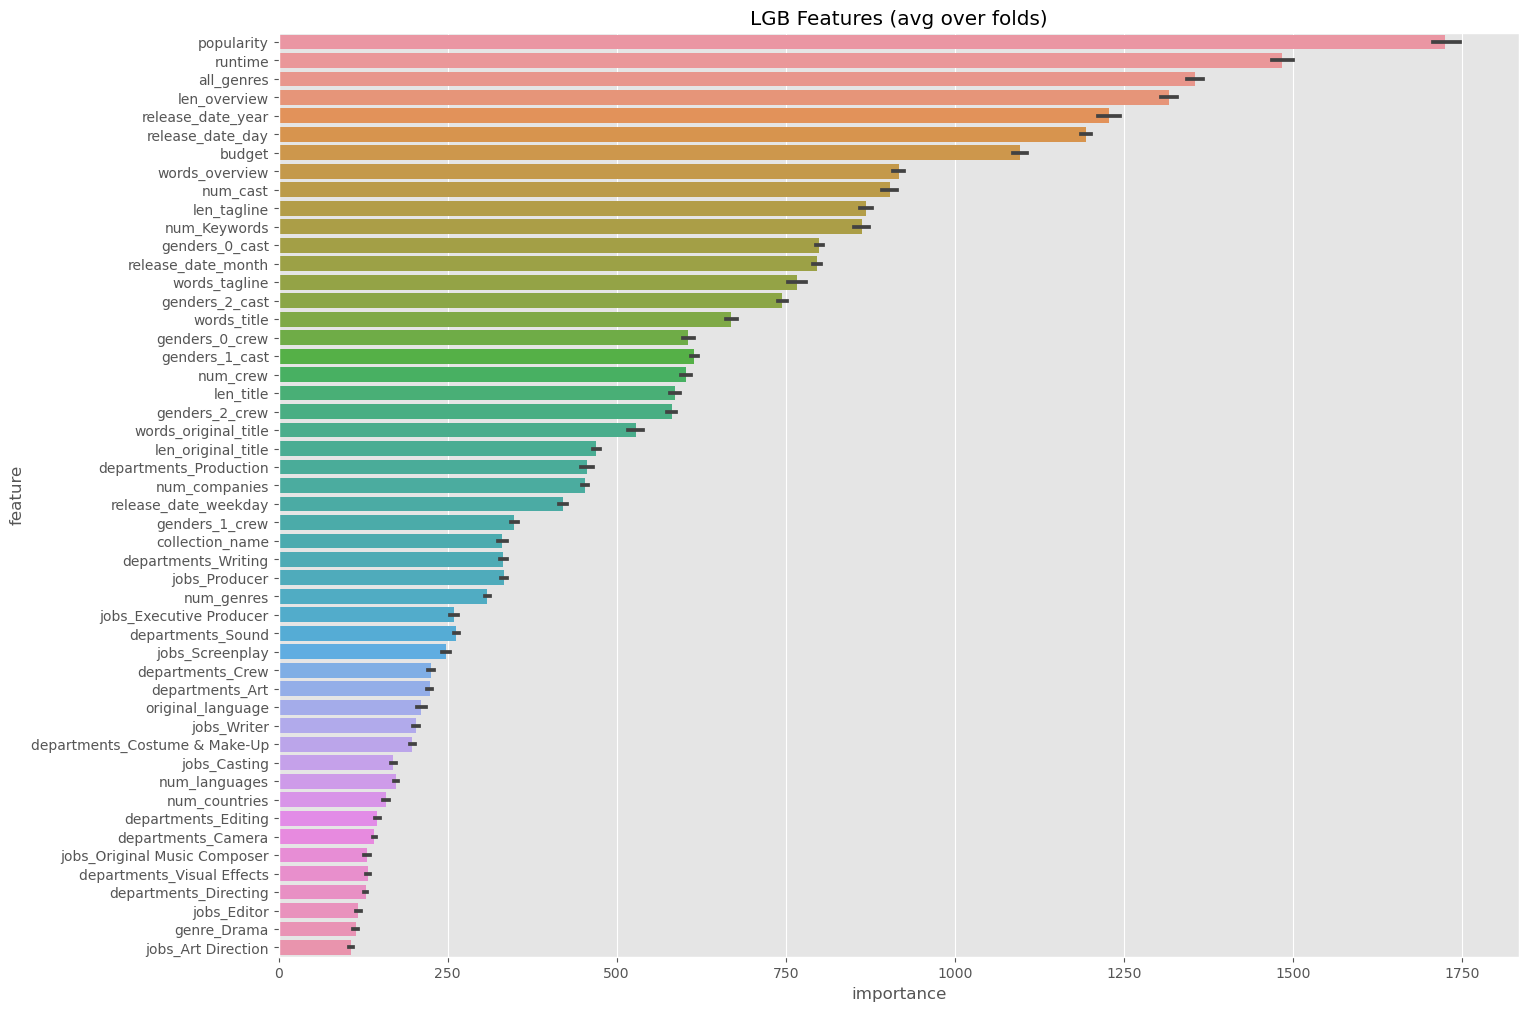

In [182]:
params = {
    'num_leaves': 30,
    'min_data_in_leaf': 10,
    'objective': 'regression',
    'max_depth': 5,
    'learning_rate': 0.01,
    "boosting": "goss",
    "feature_fraction": 0.9,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "verbosity": -1
}
oof_lgb, prediction_lgb, _ = train_model_lgb(X, X_test, y, params=params, folds=folds, plot_feature_importance=True)